In [1]:
import flv_utils as flv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_reversal_fraction(velocity, window_size=200):
    """
    Compute fraction of time in reversal over half-overlapping rolling windows.
    
    Parameters:
    -----------
    velocity : array-like
        Velocity data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    reversal_fractions : numpy array
        Array of reversal fractions for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    velocity = np.array(velocity)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Create forward/reverse boolean array (True = forward, False = reverse)
    fwd_rev = velocity > 0
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(velocity) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(velocity)})")
    
    # Initialize arrays for results
    reversal_fractions = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling reversal fraction with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = fwd_rev[start_idx:end_idx]
        
        # Calculate fraction of time in reversal (velocity <= 0)
        reversal_fraction = np.sum(~window) / window_size  # ~window gives reverse periods
        reversal_fractions[i] = reversal_fraction
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return reversal_fractions, window_centers

def compute_binned_velocities(velocity, window_size=200):
    """
    Compute mean absolute velocity over half-overlapping rolling windows.
    
    Parameters:
    -----------
    velocity : array-like
        Velocity data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    binned_velocities : numpy array
        Array of mean absolute velocities for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    velocity = np.array(velocity)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Calculate absolute velocities
    abs_velocity = np.abs(velocity)
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(velocity) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(velocity)})")
    
    # Initialize arrays for results
    binned_velocities = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling mean absolute velocity with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = abs_velocity[start_idx:end_idx]
        
        # Calculate mean absolute velocity
        binned_velocities[i] = np.mean(window)
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return binned_velocities, window_centers


def compute_binned_pumping_rates(pumping_rate, window_size=200):
    """
    Compute mean pumping rate over half-overlapping rolling windows.
    
    Parameters:
    -----------
    pumping_rate : array-like
        Pumping rate data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    binned_pumping_rates : numpy array
        Array of mean pumping rates for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    pumping_rate = np.array(pumping_rate)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(pumping_rate) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(pumping_rate)})")
    
    # Initialize arrays for results
    binned_pumping_rates = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling mean pumping rate with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = pumping_rate[start_idx:end_idx]
        
        # Calculate mean pumping rate
        binned_pumping_rates[i] = np.mean(window)
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return binned_pumping_rates, window_centers

In [3]:
def compute_below_zero_ratio(array):
    """
    Compute the ratio of below-zero values to total defined values for each row.
    
    Parameters:
    array: numpy array of shape (n_rows, n_cols) with potential NaN values
    
    Returns:
    numpy array of shape (n_rows,) containing ratios for each row
    """

    n_rows, n_cols = array.shape
    # Count defined (non-NaN) values per row
    defined_counts = np.sum(~np.isnan(array), axis=1)
    
    # Count below-zero values per row (NaN values are ignored by default in comparisons)
    below_zero_counts = np.sum(array < 0, axis=1)
    
    # Compute ratio, handling division by zero
    ratios = np.divide(below_zero_counts, defined_counts, 
                      out=np.zeros(n_rows), where=defined_counts != 0)
    
    return ratios


def flag_onset_transitions(binary_array):
    """
    Vectorized version for better performance.
    """
    n_animals, n_timepoints = binary_array.shape
    
    # Initialize flag array with zeros
    flag_array = np.zeros_like(binary_array)
    
    # Find animals that end with 0 in the last timepoint OR end with NaN
    # (animals ending with 1 should be excluded)
    last_values = binary_array[:, -1]
    animals_ending_zero = (last_values == 0) | np.isnan(last_values)
    
    # Handle first timepoint (onset from implicit 0 state)
    first_is_one = (binary_array[:, 0] == 1) & animals_ending_zero
    flag_array[first_is_one, 0] = 1
    
    if n_timepoints > 1:
        # Create shifted arrays to compare adjacent timepoints
        current = binary_array[:, 1:]  # timepoints 1 to end
        previous = binary_array[:, :-1]  # timepoints 0 to end-1
        
        # Find 0->1 transitions: previous==0 AND current==1
        transitions = (previous == 0) & (current == 1)
        
        # Only keep transitions for animals that end with 0
        transitions = transitions & animals_ending_zero[:, np.newaxis]
        
        # Place transition flags in the correct positions (at timepoint where 1 occurs)
        flag_array[:, 1:][transitions] = 1
    
    # Keep NaN values as NaN in the flag array
    flag_array[np.isnan(binary_array)] = np.nan
    
    return flag_array

In [4]:
# Gather behavior data over time for each animal
# Fill empty time points with nan to make an array of (n_animal, length_max)

all_conditions = ['dense_food', 'sparse_food', 'just_fed', 'fasted', 'starved', 'heat_stim', 'before_after_stim', 'octanol', 'gfp']
all_reversal_fractions = dict()
all_velocities = dict()
all_speeds = dict()
all_head_curvatures = dict()
all_reorientations = dict()
all_pumping_rates = dict()
all_mean_speed = dict()
all_mean_pumping = dict()
all_frac_rev = dict()
all_uids = dict()
# Add dictionaries for binned speed and pumping rates
all_binned_speeds = dict()
all_binned_pumping = dict()

behs = ['velocity', 'head_angle', 'pumping', 'reversal_vec']
sentinel = "M3"   # this neuron is found in every dataset when set confidence=1
window_size = 50
length_max = 1600

for condition in all_conditions:
    # pull all relevant behavior traces    
    if condition == 'sparse_food':

        include = ['neuropal', 'stim']
        exclude = ['gfp']
        length_bounds=(800,800)
        data0 = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)     
        
        include = ['neuropal', 'baseline']
        exclude = ['gfp']
        length_bounds=(800,1600)
        data1 = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
                
        uniq_animals = []
        idx_all_0 = []
        for i, animal in enumerate(data0['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all_0.append(i)
        
        idx_all_1 = []
        for i, animal in enumerate(data1['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all_1.append(i)
        
        n_animals = len(idx_all_0) + len(idx_all_1)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for any trace length
        max_windows = length_max - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan

        for i, animal in enumerate(idx_all_0):
            v = data0['behavior_traces']['velocity'][animal][:800]
            theta = data0['behavior_traces']['head_angle'][animal][:800]
            p = data0['behavior_traces']['pumping'][animal][:800]
            av = data0['behavior_traces']['reversal_vec'][animal][:800]
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp
                    
        for i, animal in enumerate(idx_all_1):
            v = data1['behavior_traces']['velocity'][animal]
            theta = data1['behavior_traces']['head_angle'][animal]
            p = data1['behavior_traces']['pumping'][animal]
            av = data1['behavior_traces']['reversal_vec'][animal]
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            nt = len(v)
            velocities[i+len(idx_all_0), :nt] = v
            head_curvatures[i+len(idx_all_0), :nt] = theta
            pumping_rates[i+len(idx_all_0), :nt] = p
            reorientations[i+len(idx_all_0), :nt] = av
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i+len(idx_all_0), :n_windows] = rf
            binned_speeds[i+len(idx_all_0), :n_windows] = bv
            binned_pumping[i+len(idx_all_0), :n_windows] = bp

    elif condition == 'heat_stim':
        include = ['neuropal', 'stim']
        exclude = ['gfp']
        length_bounds=(1600,1615)
        data = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
        uniq_animals = []
        idx_all = []
        for i, animal in enumerate(data['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all.append(i)
        
        n_animals = len(idx_all)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for truncated traces (810: onwards)
        max_trace_length = 1615 - 810  # ~800 time points
        max_windows = max_trace_length - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan
        
        for i, animal in enumerate(idx_all):
            v = data['behavior_traces']['velocity'][animal][810:]
            theta = data['behavior_traces']['head_angle'][animal][810:]
            p = data['behavior_traces']['pumping'][animal][810:]
            av = data['behavior_traces']['reversal_vec'][animal][810:]
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp
    
    else:
        if condition == 'dense_food':
            include = ['neuropal', 'refed']
            exclude = ['gfp']
            length_bounds=(799,800)

        elif condition == 'just_fed':
            include = ['neuropal', 'just_fed']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'fasted':
            include = ['neuropal', 'fasted']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'starved':
            include = ['neuropal', 'very_starved']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'copper':
            include = ['neuropal', 'copper']
            exclude = ['gfp']
            length_bounds=(800,1600) 

        elif condition == 'octanol':
            include = ['neuropal', 'octanol']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(800,1600) 

        elif condition == 'diacetyl':
            include = ['neuropal', 'diacetyl']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(800,1600) 

        elif condition == 'before_after_stim':
            include = ['neuropal', 'stim']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(1600,1600) 

        elif condition == 'gfp':
            include = ['neuropal', 'gfp']
            exclude=[]
            length_bounds=(1600,1600)
        
        data = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
        uniq_animals = []
        idx_all = []
        for i, animal in enumerate(data['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all.append(i)
        
        n_animals = len(idx_all)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for this condition's trace lengths
        max_windows = length_max - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan
        
        for i, animal in enumerate(idx_all):
            v = data['behavior_traces']['velocity'][animal]
            theta = data['behavior_traces']['head_angle'][animal]
            p = data['behavior_traces']['pumping'][animal]
            av = data['behavior_traces']['reversal_vec'][animal]
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp

    all_velocities[condition] = velocities
    all_speeds[condition] = np.abs(velocities)
    all_head_curvatures[condition] = head_curvatures
    all_reorientations[condition] = flag_onset_transitions(reorientations)
    all_pumping_rates[condition] = pumping_rates
    all_reversal_fractions[condition] = reversal_fractions
    all_binned_speeds[condition] = binned_speeds
    all_binned_pumping[condition] = binned_pumping
    all_mean_speed[condition] = np.nanmean(np.abs(velocities), axis=1)
    all_mean_pumping[condition] = np.nanmean(pumping_rates, axis=1)
    all_frac_rev[condition] = compute_below_zero_ratio(all_velocities[condition])
    all_uids[condition] = uniq_animals
    
    print(f"{condition}, n = {len(uniq_animals)}")

dense_food, n = 8
sparse_food, n = 40
just_fed, n = 20
fasted, n = 19
starved, n = 21


/tmp/ipykernel_207277/3917535654.py:134: RuntimeWarning: invalid value encountered in multiply
  reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
/tmp/ipykernel_207277/3917535654.py:135: RuntimeWarning: invalid value encountered in multiply
  binned_speeds = np.empty((n_animals, max_windows)) * np.nan
/tmp/ipykernel_207277/3917535654.py:136: RuntimeWarning: invalid value encountered in multiply
  binned_pumping = np.empty((n_animals, max_windows)) * np.nan


heat_stim, n = 19


/tmp/ipykernel_207277/3917535654.py:216: RuntimeWarning: invalid value encountered in multiply
  velocities = np.empty((n_animals, length_max)) * np.nan
/tmp/ipykernel_207277/3917535654.py:217: RuntimeWarning: invalid value encountered in multiply
  head_curvatures = np.empty((n_animals, length_max)) * np.nan
/tmp/ipykernel_207277/3917535654.py:218: RuntimeWarning: invalid value encountered in multiply
  reorientations = np.empty((n_animals, length_max)) * np.nan


before_after_stim, n = 19
octanol, n = 20
gfp, n = 14


In [90]:
groups = ['dense_food', 'sparse_food', 'diacetyl', 'just_fed', 'fasted', 'starved', 'octanol', 'heat_stim', 'before_after_stim', 'gfp'] 

dict_color = dict()
dict_color['dense_food']  = 'saddlebrown'
dict_color['sparse_food'] = 'darkorange'
dict_color['diacetyl']    = 'deeppink'
dict_color['just_fed']    = 'dodgerblue'
dict_color['fasted']      = 'lightseagreen'
dict_color['starved']     = 'darkgreen'
dict_color['octanol']     = 'navy'
dict_color['heat_stim']   = 'darkred'
dict_color['gfp']         = 'lightgrey'

In [46]:
# Copy all 'just_fed' data to 'diacetyl' for all available dictionaries
all_reorientations['diacetyl'] = all_reorientations['just_fed'] 
all_velocities['diacetyl'] = all_velocities['just_fed'] 
all_speeds['diacetyl'] = all_speeds['just_fed'] 
all_head_curvatures['diacetyl'] = all_head_curvatures['just_fed'] 
all_pumping_rates['diacetyl'] = all_pumping_rates['just_fed']
all_mean_pumping['diacetyl'] = all_mean_pumping['just_fed'] 
all_mean_speed['diacetyl'] = all_mean_speed['just_fed'] 
all_frac_rev['diacetyl'] = all_frac_rev['just_fed'] 
all_reversal_fractions['diacetyl'] = all_reversal_fractions['just_fed']
all_binned_speeds['diacetyl'] = all_binned_speeds['just_fed']
all_binned_pumping['diacetyl'] = all_binned_pumping['just_fed']
all_uids['diacetyl'] = all_uids['just_fed']

## Visualize trends over time

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create figure and 3D subplot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D line plots with median trajectories
for group in groups:
    # Find the maximum length across all animals in this group to determine array size
    max_length = max(len(all_binned_speeds[group][animal]) for animal in range(len(all_binned_speeds[group])))
    
    # Create arrays padded with NaN to handle different lengths
    speeds_padded = np.full((len(all_binned_speeds[group]), max_length), np.nan)
    reversals_padded = np.full((len(all_reversal_fractions[group]), max_length), np.nan)
    pumping_padded = np.full((len(all_binned_pumping[group]), max_length), np.nan)
    
    # Fill arrays with actual data (keeping NaN for missing values)
    for animal in range(len(all_binned_speeds[group])):
        speed_data = all_binned_speeds[group][animal]
        reversal_data = all_reversal_fractions[group][animal]
        pumping_data = all_binned_pumping[group][animal]
        
        # Only fill up to the length of available data
        speeds_padded[animal, :len(speed_data)] = speed_data
        reversals_padded[animal, :len(reversal_data)] = reversal_data
        pumping_padded[animal, :len(pumping_data)] = pumping_data
    
    # Compute nanmedian across animals for each time point
    median_speeds = np.nanmedian(speeds_padded, axis=0)
    median_reversals = np.nanmedian(reversals_padded, axis=0)
    median_pumping = np.nanmedian(pumping_padded, axis=0)
    
    # Remove time points where all values are NaN (if any)
    valid_timepoints = ~(np.isnan(median_speeds) & np.isnan(median_reversals) & np.isnan(median_pumping))
    median_speeds = median_speeds[valid_timepoints]
    median_reversals = median_reversals[valid_timepoints]
    median_pumping = median_pumping[valid_timepoints]
    
    # Plot median trajectory line
    ax.plot(median_pumping, 
            median_speeds, 
            median_reversals, 
            color=dict_color[group], 
            alpha=0.7, 
            linewidth=2,
            label=group)

# Create legend
ax.legend()

# Set labels
ax.set_xlabel('Pumping rate')
ax.set_ylabel('Speed')
ax.set_zlabel('P(reversal)')

# Add title
ax.set_title('Median Behavioral Trajectory over Time')

# Add grid
ax.grid(True)

# Improve viewing angle
ax.view_init(elev=20, azim=45)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create figure and 3D subplot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D line plots
for group in ['dense_food', 'sparse_food', 'just_fed']:
    for animal in range(len(all_velocities[group])):
        # Plot lines connecting points over time
        ax.plot(all_binned_speeds[group][animal], 
               all_reversal_fractions[group][animal], 
               all_binned_pumping[group][animal], 
               color=dict_color[group], 
               alpha=0.5, 
               linewidth=1)

# Create legend manually to avoid duplicate entries
legend_elements = []
for group in ['dense_food', 'sparse_food', 'just_fed']:
    legend_elements.append(plt.Line2D([0], [0], color=dict_color[group], 
                                     lw=2, label=group))

ax.legend(handles=legend_elements)

# Set labels
ax.set_xlabel('Speed')
ax.set_ylabel('P(reversal)')
ax.set_zlabel('Pumping rate')

# Add title
ax.set_title('Behavioral Trajectory over Time\n(Circles: Start, Squares: End)')

# Add grid
ax.grid(True)

# Improve viewing angle
ax.view_init(elev=20, azim=45)

# Show plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_207277/35785743.py:14: RuntimeWarning: All-NaN slice encountered
  median_data = np.nanmedian(data, axis=0)


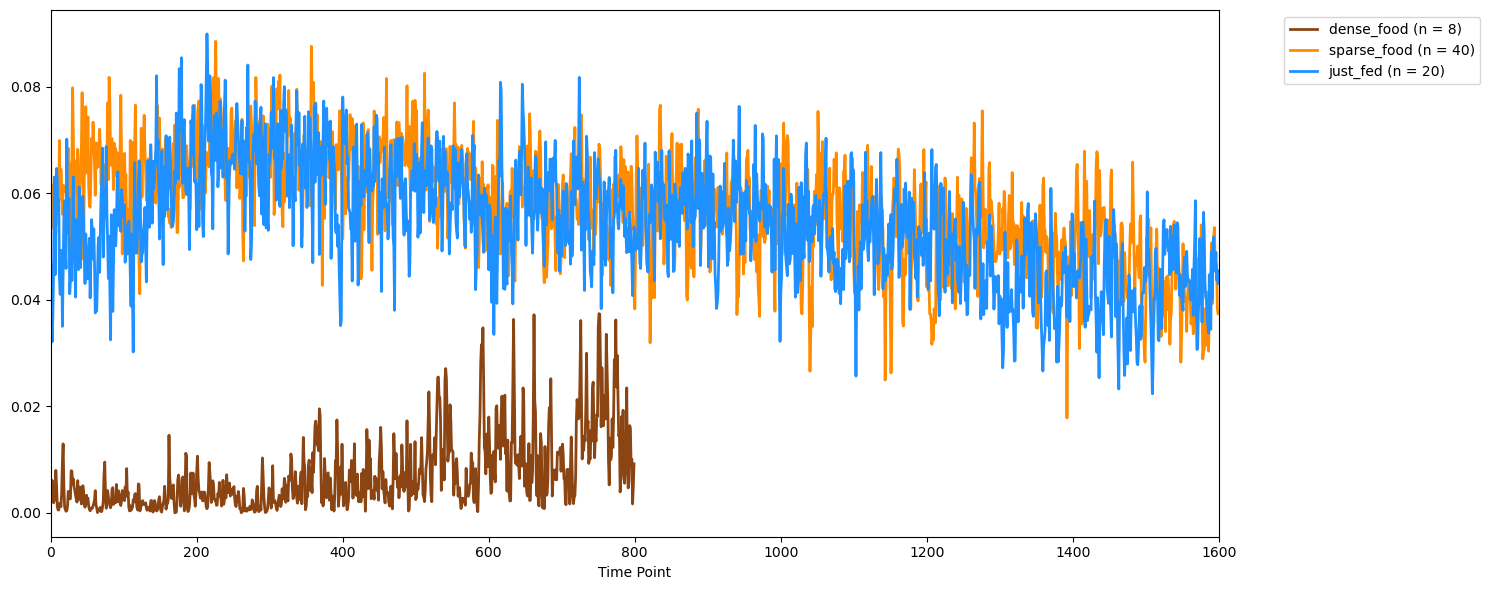

In [18]:
# Behavior over time

data_dict = all_speeds

plt.figure(figsize=(15, 6))

for group in ['dense_food', 'sparse_food', 'just_fed']:
    if group == "gfp": 
        continue
    data = data_dict[group]
    n_animals = data.shape[0]
    
    # Compute median and std across animals
    median_data = np.nanmedian(data, axis=0)
    std_data = np.nanstd(data, axis=0)
    
    # Create x-axis (assuming this represents your window centers or time points)
    x = np.arange(len(median_data))
    
    # Plot the median line
    plt.plot(x, median_data, color=dict_color[group], linewidth=2, 
             label=f"{group} (n = {n_animals})")
    
    # # Add shaded region for median +/- 1 std
    # plt.fill_between(x, median_data - std_data, median_data + std_data, 
    #                  color=dict_color[group], alpha=0.1)

plt.xlim(0,1600)
# plt.ylim(0.2, 0.7)
plt.xlabel('Time Point')
# plt.ylabel('Reversal Fraction')
# plt.title('Reversal Fractions Across Conditions')

# Place legend outside and to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for legend
plt.tight_layout()
plt.show()

/tmp/ipykernel_207277/1488698277.py:15: RuntimeWarning: All-NaN slice encountered
  median_data = np.nanmedian(data, axis=0)
/home/candy/.conda/envs/pymc-env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


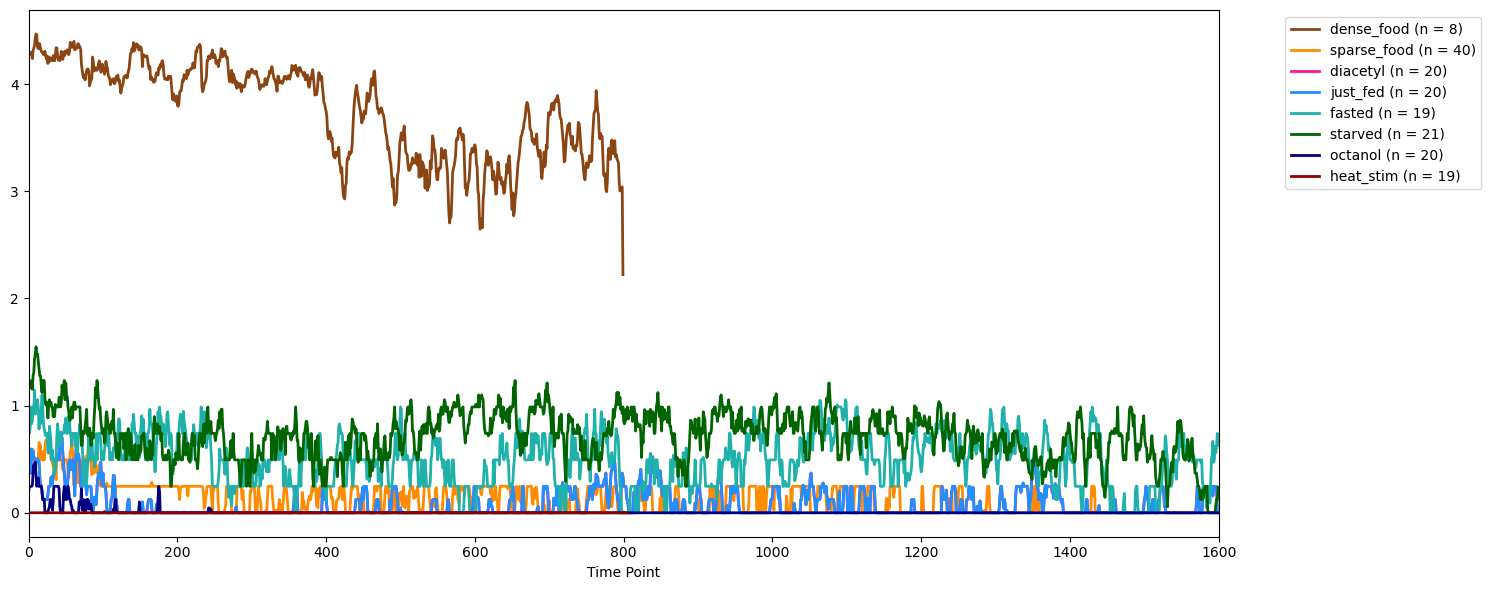

In [15]:
# Behavior over time

data_dict = all_pumping_rates

plt.figure(figsize=(15, 6))


for group in groups:
    if group == "gfp": 
        continue
    data = data_dict[group]
    n_animals = data.shape[0]
    
    # Compute median and std across animals
    median_data = np.nanmedian(data, axis=0)
    std_data = np.nanstd(data, axis=0)
    
    # Create x-axis (assuming this represents your window centers or time points)
    x = np.arange(len(median_data))
    
    # Plot the median line
    plt.plot(x, median_data, color=dict_color[group], linewidth=2, 
             label=f"{group} (n = {n_animals})")
    
    # # Add shaded region for median +/- 1 std
    # plt.fill_between(x, median_data - std_data, median_data + std_data, 
    #                  color=dict_color[group], alpha=0.1)

plt.xlim(0,1600)
# plt.ylim(0.2, 0.7)
plt.xlabel('Time Point')
# plt.ylabel('Reversal Fraction')
# plt.title('Reversal Fractions Across Conditions')

# Place legend outside and to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for legend
plt.tight_layout()
plt.show()

/tmp/ipykernel_207277/3746209996.py:4: RuntimeWarning: Mean of empty slice
  median_curve = np.nanmean(cum_reorientations, axis=0)


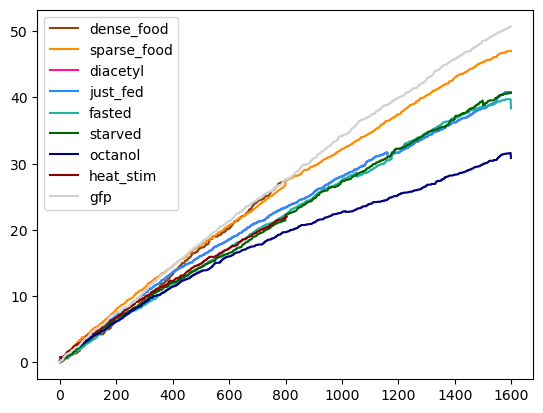

In [17]:
# Cumulative reorientation rates from data alone
for (idx, group) in enumerate(groups):
    cum_reorientations = np.cumsum(all_reorientations[group], axis=1)
    median_curve = np.nanmean(cum_reorientations, axis=0)
    std_curve = np.nanstd(cum_reorientations, axis=0)  # Fixed typo: std_cruve -> std_curve
    
    # Plot the median line
    plt.plot(median_curve, c=dict_color[group], alpha=1, label=group)

plt.legend()

/tmp/ipykernel_3206248/962986410.py:8: RuntimeWarning: Mean of empty slice
  median_curve = np.nanmean(cum_reorientations, axis=0)
/tmp/ipykernel_3206248/962986410.py:17: RuntimeWarning: Mean of empty slice
  bootstrap_mean = np.nanmean(bootstrap_sample, axis=0)
/home/candy/.conda/envs/pymc-env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


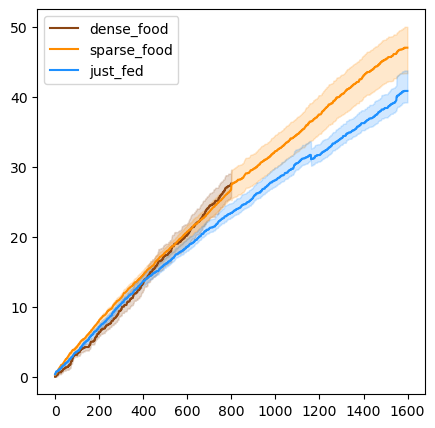

In [28]:
# Using bootstrap percentiles (e.g., 95% confidence interval)
n_bootstrap = 100

plt.figure(figsize=(5,5))

for (idx, group) in enumerate(['dense_food', 'sparse_food', 'just_fed']):
    cum_reorientations = np.cumsum(all_reorientations[group], axis=1)
    median_curve = np.nanmean(cum_reorientations, axis=0)
    
    # Bootstrap resampling
    bootstrap_curves = []
    n_samples = cum_reorientations.shape[0]
    
    for _ in range(n_bootstrap):
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_sample = cum_reorientations[bootstrap_indices]
        bootstrap_mean = np.nanmean(bootstrap_sample, axis=0)
        bootstrap_curves.append(bootstrap_mean)
    
    bootstrap_curves = np.array(bootstrap_curves)
    
    # Calculate percentiles (e.g., 2.5th and 97.5th for 95% CI)
    # lower_bound = np.nanpercentile(bootstrap_curves, 2.5, axis=0)
    # upper_bound = np.nanpercentile(bootstrap_curves, 97.5, axis=0)
    
    # Calculate percentiles equivalent to ±1 standard deviation
    lower_bound = np.nanpercentile(bootstrap_curves, 16, axis=0)
    upper_bound = np.nanpercentile(bootstrap_curves, 84, axis=0)
    
    # Plot the median line
    plt.plot(median_curve, c=dict_color[group], alpha=1, label=group)
    
    # Add shaded region for bootstrap confidence interval
    x = np.arange(len(median_curve))
    plt.fill_between(x, lower_bound, upper_bound, 
                     color=dict_color[group], alpha=0.2)

plt.legend()

/tmp/ipykernel_3206248/4192717939.py:15: RuntimeWarning: Mean of empty slice
  median_curve = np.nanmean(cum_reorientations, axis=0)


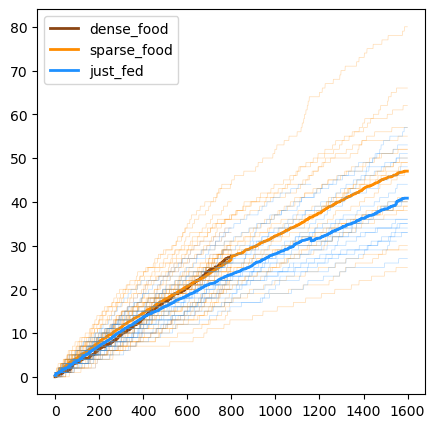

In [29]:
# Plot individual animal cumulative reorientation curves
plt.figure(figsize=(5,5))

for (idx, group) in enumerate(['dense_food', 'sparse_food', 'just_fed']):
    cum_reorientations = np.cumsum(all_reorientations[group], axis=1)
    
    # Plot each individual animal
    for i in range(cum_reorientations.shape[0]):
        plt.plot(cum_reorientations[i], 
                color=dict_color[group], 
                alpha=0.3,  # Semi-transparent individual lines
                linewidth=0.5)
    
    # Plot group mean as a thicker line
    median_curve = np.nanmean(cum_reorientations, axis=0)
    plt.plot(median_curve, 
            color=dict_color[group], 
            alpha=1, 
            linewidth=2,
            label=group)

plt.legend()

## NHPP for reorientation events -- frequentist optimization for a generative model with the best AIC

In [31]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple, Optional
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp
import warnings

# =========================
# Data prep
# =========================

def prep_event_data(events: np.ndarray, t: np.ndarray | None = None
                   ) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray]]:
    """
    events: (n_animals, T) array with {0,1} and NaN padding after last observed point
    Returns:
      flat_y, flat_t: pooled vectors over all animals
      seqs: list of per-animal 1D arrays (for HMM and per-animal fits)
    """
    n_animals, T = events.shape
    if t is None:
        t = np.arange(T, dtype=float)
    flat_y, flat_t, seqs = [], [], []
    for i in range(n_animals):
        mask = ~np.isnan(events[i])
        y_i = events[i, mask].astype(int)
        if y_i.size == 0:
            continue
        t_i = t[mask]
        flat_y.append(y_i); flat_t.append(t_i); seqs.append(y_i)
    return (np.concatenate(flat_y) if flat_y else np.array([], int),
            np.concatenate(flat_t) if flat_t else np.array([], float),
            seqs)

# Poisson log-likelihood in discrete bins
def poisson_loglik(y: np.ndarray, lam: np.ndarray) -> float:
    eps = 1e-12
    lam = np.clip(lam, eps, None)
    
    # Handle potential numerical issues
    with np.errstate(invalid='ignore', over='ignore'):
        log_lam = np.log(lam)
        result = np.sum(y * log_lam - lam - gammaln(y + 1))
    
    # Return -inf if result is invalid (prevents optimizer from exploring bad regions)
    if np.isnan(result) or np.isinf(result):
        return -np.inf
    return result

def aic(loglik: float, k: int) -> float:
    return 2 * k - 2 * loglik

def bic(loglik: float, k: int, n_obs: int) -> float:
    return k * np.log(max(n_obs, 1)) - 2 * loglik

# =========================
# Models (stationary, linear log-link, exponential level, 2-state HMM)
# =========================

@dataclass
class FitResult:
    name: str
    loglik: float
    k: int
    n_obs: int
    params: Dict[str, Any]
    converged: bool = True
    n_iter: int = 0

# --- Stationary ---
def fit_stationary(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("stationary", -np.inf, 1, 0, {})
    lam_hat = float(np.mean(y))
    ll = poisson_loglik(y, np.full_like(y, lam_hat, dtype=float))
    return FitResult("stationary", ll, 1, y.size, {"lam": lam_hat})

# --- Linear drift (log λ = β0 + β1 t) ---
def fit_linear(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("linear", -np.inf, 2, 0, {})
    
    def nll(par):
        b0, b1 = par
        # Prevent extreme parameter values that cause overflow
        b0 = np.clip(b0, -20, 20)  # Prevents exp(b0) overflow
        b1 = np.clip(b1, -1, 1)    # Reasonable range for trend
        
        log_lam = b0 + b1 * t
        log_lam = np.clip(log_lam, -20, 20)  # Additional safety
        lam = np.exp(log_lam)
        
        ll = poisson_loglik(y, lam)
        if np.isnan(ll) or np.isinf(ll):
            return 1e10  # Large penalty for invalid parameters
        return -ll
    
    # Better initialization
    mean_y = np.mean(y)
    init = [np.log(max(mean_y, 1e-6)), 0.0]
    
    # Add bounds to prevent extreme values
    bounds = [(-20, 20), (-1, 1)]  # Reasonable bounds for b0 and b1
    
    try:
        res = minimize(nll, init, method="L-BFGS-B", bounds=bounds)
        b0, b1 = res.x
        final_ll = -res.fun if res.success else -1e10
    except:
        # Fallback if optimization fails
        b0, b1 = init
        final_ll = -nll(init)
    
    return FitResult("linear", final_ll, 2, y.size, {"beta0": b0, "beta1": b1})

# --- Exponential drift (λ(t) = A e^{-t/τ} + C, A,τ,C>0) ---
def fit_exponential(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("exponential", -np.inf, 3, 0, {})
    
    def nll(par):
        a, g, c = par
        # Clip parameters to prevent overflow
        a = np.clip(a, -20, 20)
        g = np.clip(g, -10, 10)
        c = np.clip(c, -20, 20)
        
        A, tau, C = np.exp(a), np.exp(g), np.exp(c)
        
        # Additional safety for extreme values
        tau = np.clip(tau, 1e-6, 1e6)
        
        with np.errstate(over='ignore', invalid='ignore'):
            lam = A * np.exp(-t / tau) + C
        
        # Ensure lambda values are reasonable
        lam = np.clip(lam, 1e-10, 1e10)
        
        ll = poisson_loglik(y, lam)
        if np.isnan(ll) or np.isinf(ll):
            return 1e10
        return -ll
    
    mean_y = max(np.mean(y), 1e-6)
    t_range = max((t.max() - t.min()), 1.0)
    init = [np.log(mean_y/2), np.log(t_range/3), np.log(mean_y/2)]
    
    # Add reasonable bounds
    bounds = [(-20, 20), (-10, 10), (-20, 20)]
    
    try:
        res = minimize(nll, init, method="L-BFGS-B", bounds=bounds)
        a, g, c = res.x
        A, tau, C = np.exp(a), np.exp(g), np.exp(c)
        final_ll = -res.fun if res.success else -1e10
    except:
        # Fallback
        a, g, c = init
        A, tau, C = np.exp(a), np.exp(g), np.exp(c)
        final_ll = -nll(init)
    
    return FitResult("exponential", final_ll, 3, y.size, {"A": A, "tau": tau, "C": C})

# --- Two-state Poisson HMM (EM) ---
def fb_poisson_stable(y: np.ndarray, lam: np.ndarray, A: np.ndarray, pi: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Forward-backward algorithm with improved numerical stability for Poisson HMM.
    Uses log-space computations where possible.
    """
    T = len(y)
    S = len(lam)
    
    # Compute emission probabilities in log space
    # Add small constant to lambda to prevent log(0)
    lam_safe = np.maximum(lam, 1e-10)
    log_b = np.zeros((T, S))
    for k in range(S):
        log_b[:, k] = y * np.log(lam_safe[k]) - lam_safe[k] - gammaln(y + 1)
    
    # Forward pass in log space
    log_alpha = np.zeros((T, S))
    log_alpha[0] = np.log(pi + 1e-300) + log_b[0]
    
    for t in range(1, T):
        # Use logsumexp for numerical stability
        for j in range(S):
            log_alpha[t, j] = logsumexp(log_alpha[t-1] + np.log(A[:, j] + 1e-300)) + log_b[t, j]
    
    # Log likelihood
    ll = logsumexp(log_alpha[-1])
    
    # Backward pass in log space
    log_beta = np.zeros((T, S))
    log_beta[-1] = 0  # log(1) = 0
    
    for t in range(T-2, -1, -1):
        for i in range(S):
            log_beta[t, i] = logsumexp(np.log(A[i, :] + 1e-300) + log_b[t+1] + log_beta[t+1])
    
    # Compute gamma (state posteriors)
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)
    
    # Compute xi (transition posteriors)
    xi = np.zeros((T-1, S, S))
    for t in range(T-1):
        log_xi_t = np.zeros((S, S))
        for i in range(S):
            for j in range(S):
                log_xi_t[i, j] = (log_alpha[t, i] + np.log(A[i, j] + 1e-300) + 
                                  log_b[t+1, j] + log_beta[t+1, j])
        log_xi_t -= logsumexp(log_xi_t)
        xi[t] = np.exp(log_xi_t)
    
    return ll, gamma, xi

def initialize_parameters(seqs: List[np.ndarray], 
                         low_transition: bool = True,
                         transition_prob: float = 0.01) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Smart initialization for HMM parameters.
    
    Args:
        seqs: List of observation sequences
        low_transition: If True, initialize with low transition probabilities
        transition_prob: Off-diagonal transition probability (if low_transition=True)
    """
    y_all = np.concatenate(seqs)
    
    # Use k-means style initialization for lambda values
    # This helps separate the two states better
    percentiles = np.percentile(y_all, [25, 75])
    
    # Initialize lambdas based on data distribution
    low_mask = y_all <= percentiles[0]
    high_mask = y_all >= percentiles[1]
    
    if low_mask.sum() > 0:
        lam_low = np.maximum(0.001, y_all[low_mask].mean())
    else:
        lam_low = np.maximum(0.001, y_all.mean() * 0.3)
    
    if high_mask.sum() > 0:
        lam_high = np.maximum(lam_low * 1.5, y_all[high_mask].mean())
    else:
        lam_high = np.maximum(lam_low * 1.5, y_all.mean() * 2.0)
    
    lam = np.array([lam_low, lam_high])
    
    # Initialize transition matrix
    if low_transition:
        # Low transition probability - states are "sticky"
        diag_prob = 1 - transition_prob
        A = np.array([[diag_prob, transition_prob],
                      [transition_prob, diag_prob]])
    else:
        # Default balanced transitions
        A = np.array([[0.9, 0.1],
                      [0.1, 0.9]])
    
    # Initialize stationary distribution
    # For low transition case, might want to start from stationary distribution
    if low_transition:
        # Compute stationary distribution
        pi = np.array([0.5, 0.5])  # Can be refined based on A
    else:
        pi = np.array([0.5, 0.5])
    
    return lam, A, pi

def fit_hmm2(seqs: List[np.ndarray], 
             max_iter: int = 200,
             tol: float = 1e-5,
             low_transition: bool = True,
             transition_prob: Optional[float] = None,
             fix_transition: bool = False,
             verbose: bool = False) -> FitResult:
    """
    Fit 2-state Poisson HMM with improved stability and options for low transition probability.
    This is now the UNIFIED HMM implementation used by both pooled and per-animal fitting.
    
    Args:
        seqs: List of observation sequences
        max_iter: Maximum number of EM iterations
        tol: Convergence tolerance (relative change in log-likelihood)
        low_transition: If True, initialize with low transition probabilities
        transition_prob: Initial off-diagonal transition probability (default: 0.01 if low_transition)
        fix_transition: If True, don't update transition matrix during EM (useful for very low transitions)
        verbose: Print iteration details
    
    Returns:
        FitResult with fitted parameters
    """
    if len(seqs) == 0:
        return FitResult("hmm2", -np.inf, 5, 0, {}, False, 0)
    
    # Set default transition probability for low transition case
    if transition_prob is None:
        transition_prob = 0.01 if low_transition else 0.1
    
    # Initialize parameters
    lam, A, pi = initialize_parameters(seqs, low_transition, transition_prob)
    
    if verbose:
        print(f"Initial parameters:")
        print(f"  Lambda: {lam}")
        print(f"  A: {A}")
        print(f"  Pi: {pi}")
    
    prev_ll = -np.inf
    converged = False
    
    for iter_num in range(max_iter):
        # E-step: accumulate sufficient statistics
        sum_xi = np.zeros_like(A)
        sum_gamma = np.zeros(2)
        sum_gamma_y = np.zeros(2)
        sum_gamma0 = np.zeros(2)
        ll_tot = 0.0
        
        for y in seqs:
            try:
                ll, gamma, xi = fb_poisson_stable(y, lam, A, pi)
                
                # Check for numerical issues
                if np.isnan(ll) or np.isinf(ll):
                    warnings.warn(f"Numerical issue detected at iteration {iter_num}")
                    break
                
                ll_tot += ll
                sum_xi += xi.sum(0)
                sum_gamma += gamma.sum(0)
                sum_gamma_y += gamma.T @ y
                sum_gamma0 += gamma[0]
                
            except Exception as e:
                warnings.warn(f"Error in forward-backward at iteration {iter_num}: {e}")
                break
        
        # M-step: update parameters
        eps = 1e-10
        
        # Update emission parameters (lambdas)
        lam_new = np.maximum(1e-6, sum_gamma_y / np.maximum(sum_gamma, eps))
        
        # Ensure lambdas are ordered (helps with identifiability)
        if lam_new[0] > lam_new[1]:
            lam_new = lam_new[::-1]
            # Also swap the accumulated statistics
            sum_xi = sum_xi[::-1, ::-1]
            sum_gamma = sum_gamma[::-1]
            sum_gamma0 = sum_gamma0[::-1]
        
        lam = lam_new
        
        # Update transition matrix (unless fixed)
        if not fix_transition:
            A_new = sum_xi / np.maximum(sum_xi.sum(1, keepdims=True), eps)
            
            # For low transition case, apply smoothing to keep transitions low
            if low_transition:
                # Apply Dirichlet smoothing with strong prior on diagonal
                alpha_diag = 100.0  # Strong prior on staying in same state
                alpha_off = 1.0     # Weak prior on transitions
                
                prior = np.array([[alpha_diag, alpha_off],
                                  [alpha_off, alpha_diag]])
                
                A_new = (sum_xi + prior) / np.maximum((sum_xi + prior).sum(1, keepdims=True), eps)
            
            A = A_new
        
        # Update initial distribution
        pi = sum_gamma0 / np.maximum(sum_gamma0.sum(), eps)
        
        # Check convergence
        rel_change = abs(ll_tot - prev_ll) / (1 + abs(ll_tot))
        
        if verbose and iter_num % 10 == 0:
            print(f"Iteration {iter_num}: LL = {ll_tot:.4f}, Rel. change = {rel_change:.6f}")
            print(f"  Lambda: {lam}")
            print(f"  A diagonal: {np.diag(A)}")
        
        if rel_change < tol:
            converged = True
            if verbose:
                print(f"Converged after {iter_num + 1} iterations")
            break
        
        prev_ll = ll_tot
    
    if not converged and verbose:
        print(f"Did not converge after {max_iter} iterations")
    
    # Calculate total observations
    n_obs = sum(len(seq) for seq in seqs)
    
    # Number of parameters: 2 lambdas + 2 transition probs + 1 initial prob
    n_params = 5
    
    # Return with exact same attribute names as original
    return FitResult(
        name="hmm2",
        loglik=prev_ll,
        k=n_params,
        n_obs=n_obs,
        params={"lam": lam, "A": A, "pi": pi},
        converged=converged,
        n_iter=iter_num + 1
    )

def decode_states(y: np.ndarray, lam: np.ndarray, A: np.ndarray, pi: np.ndarray) -> np.ndarray:
    """
    Viterbi decoding to find most likely state sequence.
    """
    T = len(y)
    S = len(lam)
    
    # Compute emission probabilities in log space
    lam_safe = np.maximum(lam, 1e-10)
    log_b = np.zeros((T, S))
    for k in range(S):
        log_b[:, k] = y * np.log(lam_safe[k]) - lam_safe[k] - gammaln(y + 1)
    
    # Viterbi algorithm in log space
    log_delta = np.zeros((T, S))
    psi = np.zeros((T, S), dtype=int)
    
    # Initialize
    log_delta[0] = np.log(pi + 1e-300) + log_b[0]
    
    # Forward pass
    for t in range(1, T):
        for j in range(S):
            temp = log_delta[t-1] + np.log(A[:, j] + 1e-300)
            psi[t, j] = np.argmax(temp)
            log_delta[t, j] = temp[psi[t, j]] + log_b[t, j]
    
    # Backward pass - reconstruct path
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(log_delta[-1])
    
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    
    return states

# =========================
# Core comparison utilities
# =========================

def _assemble_table(results: List[FitResult]) -> pd.DataFrame:
    df = pd.DataFrame([{
        "Model": r.name,
        "loglik": r.loglik,
        "k": r.k,
        "n_obs": r.n_obs,
        "AIC": aic(r.loglik, r.k),
        "Params": r.params
    } for r in results]).sort_values("AIC").reset_index(drop=True)

    # ΔAIC / Akaike weights
    min_aic = df["AIC"].min()
    df["ΔAIC"] = df["AIC"] - min_aic
    w = np.exp(-0.5 * df["ΔAIC"])
    df["Akaike weight"] = (w / w.sum()).values

    return df

def compare_models_pooled(events: np.ndarray, t: np.ndarray | None = None) -> pd.DataFrame:
    """
    Pooled fit across animals. Returns AIC/BIC table with Δ and Akaike weights.
    """
    y, tvec, seqs = prep_event_data(events, t)
    results = [
        fit_stationary(y, tvec),
        fit_linear(y, tvec),
        fit_exponential(y, tvec),
        fit_hmm2(seqs),  # Now uses the SAME implementation as per-animal
    ]
    return _assemble_table(results)

# =========================
# Per-animal fitting & summary
# =========================

def compare_models_per_animal(events: np.ndarray, t: np.ndarray | None = None
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fits each animal separately; returns:
      per_animal_df: one row per animal per model (with AIC/BIC/weights)
      summary_df: counts of model winners by AIC and by BIC
    
    FIXED: Now uses consistent data preprocessing via prep_event_data()
    """
    n_animals = events.shape[0]
    if t is None:
        t = np.arange(events.shape[1], dtype=float)

    all_rows = []
    for i in range(n_animals):
        # FIXED: Use prep_event_data for consistent preprocessing
        single_animal_events = events[i:i+1]  # Keep as 2D array for prep_event_data
        y_i, t_i, seqs_i = prep_event_data(single_animal_events, t)
        
        # Skip if no valid data after preprocessing
        if len(seqs_i) == 0 or y_i.size == 0:
            continue
            
        res = [
            fit_stationary(y_i, t_i),
            fit_linear(y_i, t_i),
            fit_exponential(y_i, t_i),
            fit_hmm2(seqs_i),  # FIXED: Now uses the SAME implementation as pooled
        ]
        df_i = _assemble_table(res)
        df_i.insert(0, "animal", i)
        all_rows.append(df_i)

    per_animal_df = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

    # Winner tallies
    if per_animal_df.empty:
        summary_df = pd.DataFrame(columns=["Criterion", "Model", "Wins"])
        return per_animal_df, summary_df

    winners_aic = (per_animal_df.loc[per_animal_df.groupby("animal")["AIC"].idxmin(), ["animal","Model"]]
                   .value_counts("Model").rename_axis("Model").reset_index(name="Wins"))

    winners_aic.insert(0, "Criterion", "AIC")
    summary_df = pd.concat([winners_aic], ignore_index=True)
    summary_df = summary_df.sort_values(["Criterion","Wins"], ascending=[True, False]).reset_index(drop=True)
    return per_animal_df, summary_df

# =========================
# Convenience wrapper
# =========================

def compare_models(events: np.ndarray, t: np.ndarray | None = None, mode: str = "pooled"):
    """
    mode: "pooled" -> pooled table only
          "per_animal" -> (per_animal_df, summary_df)
    """
    if mode == "pooled":
        return compare_models_pooled(events, t)
    elif mode == "per_animal":
        return compare_models_per_animal(events, t)
    else:
        raise ValueError("mode must be 'pooled' or 'per_animal'")

In [32]:
# Test case
# Example usage and testing
if __name__ == "__main__":
    # Generate synthetic data with low transition probability
    np.random.seed(42)
    
    # True parameters
    true_lam = np.array([1.0, 5.0])
    true_A = np.array([[0.98, 0.02],
                       [0.02, 0.98]])  # Low transition probability
    
    # Generate sequences
    n_seqs = 10
    seqs = []
    for _ in range(n_seqs):
        T = 100
        states = np.zeros(T, dtype=int)
        observations = np.zeros(T)
        
        # Initial state
        states[0] = np.random.choice(2, p=[0.5, 0.5])
        
        for t in range(1, T):
            # State transition
            states[t] = np.random.choice(2, p=true_A[states[t-1]])
        
        # Generate observations
        for t in range(T):
            observations[t] = np.random.poisson(true_lam[states[t]])
        
        seqs.append(observations)
    
    # Fit model
    print("Fitting HMM with low transition probability...")
    result = fit_hmm2(
        seqs,
        low_transition=True,
        transition_prob=0.02,
        fix_transition=False,
        verbose=True
    )
    
    print("\nFinal Results:")
    print(f"Log-likelihood: {result.loglik:.4f}")
    print(f"Converged: {result.converged}")
    print(f"Parameters:")
    print(f"  Lambda: {result.params['lam']}")
    print(f"  Transition matrix:\n{result.params['A']}")
    print(f"  Initial distribution: {result.params['pi']}")

Fitting HMM with low transition probability...
Initial parameters:
  Lambda: [0.47901235 6.54416961]
  A: [[0.98 0.02]
 [0.02 0.98]]
  Pi: [0.5 0.5]
Iteration 0: LL = -1988.5667, Rel. change = inf
  Lambda: [0.91306411 5.0633947 ]
  A diagonal: [0.97974207 0.97679007]
Converged after 5 iterations

Final Results:
Log-likelihood: -1816.0160
Converged: True
Parameters:
  Lambda: [0.93361485 5.05936328]
  Transition matrix:
[[0.98331157 0.01668843]
 [0.01961332 0.98038668]]
  Initial distribution: [0.29910263 0.70089737]


In [33]:
# Initialize dictionaries to store results for each group
pooled_results = {}
per_animal_results = {}
summary_results = {}

# Analyze each group and store results
for group in groups:
    events = all_reorientations[group]
    
    print(f"\n{'='*60}")
    print(f"GROUP: {group}")
    print(f"{'='*60}")
    
    # Pooled across animals
    pooled_df = compare_models(events, t=None, mode="pooled")
    pooled_results[group] = pooled_df
    
    print("\nPooled Analysis:")
    print(pooled_df.to_string(index=False))
    
    # Per-animal fits + winner summary
    per_animal_df, summary_df = compare_models(events, t=None, mode="per_animal")
    per_animal_results[group] = per_animal_df
    summary_results[group] = summary_df
    
    print("\nPer-Animal Winner Summary:")
    print(summary_df.to_string(index=False))

# Now you can access results later like:
# pooled_results['group_name'] - pooled model comparison table
# per_animal_results['group_name'] - detailed per-animal results
# summary_results['group_name'] - winner counts

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE - Results stored in dictionaries")
print(f"{'='*60}")
print(f"Groups analyzed: {list(pooled_results.keys())}")
print(f"Access results using:")
print(f"  - pooled_results['group_name']")
print(f"  - per_animal_results['group_name'] ")
print(f"  - summary_results['group_name']")

# Example of accessing stored results:
# print("\nExample - accessing first group's pooled results:")
# first_group = list(groups)[0]
# print(f"Best model for {first_group}:")
# best_model = pooled_results[first_group].iloc[0]
# print(f"  Model: {best_model['Model']}")
# print(f"  AIC: {best_model['AIC']:.2f}")
# print(f"  Akaike weight: {best_model['Akaike weight']:.3f}")


GROUP: dense_food

Pooled Analysis:
      Model      loglik  k  n_obs         AIC                                                                                                                                                                                            Params     ΔAIC  Akaike weight
 stationary -958.086736  1   6399 1918.173471                                                                                                                                                                      {'lam': 0.03422409751523676} 0.000000       0.652440
     linear -958.055848  2   6399 1920.111696                                                                                                                                     {'beta0': -3.374825345049001, 'beta1': 3.613623773374544e-05} 1.938224       0.247549
exponential -958.086748  3   6399 1922.173496                                                                                                                 {'A': 5.49759

In [41]:
import pickle

def save_results_to_pickle(pooled_results, per_animal_results, summary_results, 
                          base_path="results"):
    """
    Save the three results dictionaries as pickle files.
    
    Parameters:
    -----------
    pooled_results : dict
        Pooled analysis results
    per_animal_results : dict  
        Per-animal analysis results
    summary_results : dict
        Summary results
    base_path : str
        Base path for saving files (without extension)
    """
    
    # Save each dictionary
    with open(f"{base_path}_pooled.pkl", "wb") as f:
        pickle.dump(pooled_results, f)
    print(f"Saved pooled_results to {base_path}_pooled.pkl")
    
    with open(f"{base_path}_per_animal.pkl", "wb") as f:
        pickle.dump(per_animal_results, f)
    print(f"Saved per_animal_results to {base_path}_per_animal.pkl")
    
    with open(f"{base_path}_summary.pkl", "wb") as f:
        pickle.dump(summary_results, f)
    print(f"Saved summary_results to {base_path}_summary.pkl")

def load_results_from_pickle(base_path="results"):
    """
    Load the three results dictionaries from pickle files.
    
    Parameters:
    -----------
    base_path : str
        Base path for loading files (without extension)
        
    Returns:
    --------
    tuple
        (pooled_results, per_animal_results, summary_results)
    """
    
    with open(f"{base_path}_pooled.pkl", "rb") as f:
        pooled_results = pickle.load(f)
    print(f"Loaded pooled_results from {base_path}_pooled.pkl")
    
    with open(f"{base_path}_per_animal.pkl", "rb") as f:
        per_animal_results = pickle.load(f)
    print(f"Loaded per_animal_results from {base_path}_per_animal.pkl")
    
    with open(f"{base_path}_summary.pkl", "rb") as f:
        summary_results = pickle.load(f)
    print(f"Loaded summary_results from {base_path}_summary.pkl")
    
    return pooled_results, per_animal_results, summary_results

# Usage:
# Save your dictionaries
base_path = "./reorient_nhpp_20250827"
save_results_to_pickle(pooled_results, per_animal_results, summary_results, base_path)

Saved pooled_results to ./beh_nhpp_20250827_pooled.pkl
Saved per_animal_results to ./beh_nhpp_20250827_per_animal.pkl
Saved summary_results to ./beh_nhpp_20250827_summary.pkl


In [88]:
# Later, load them back
pooled_results, per_animal_results, summary_results = load_results_from_pickle(base_path="./reorient_nhpp_20250827")

Loaded pooled_results from ./reorient_nhpp_20250827_pooled.pkl
Loaded per_animal_results from ./reorient_nhpp_20250827_per_animal.pkl
Loaded summary_results from ./reorient_nhpp_20250827_summary.pkl


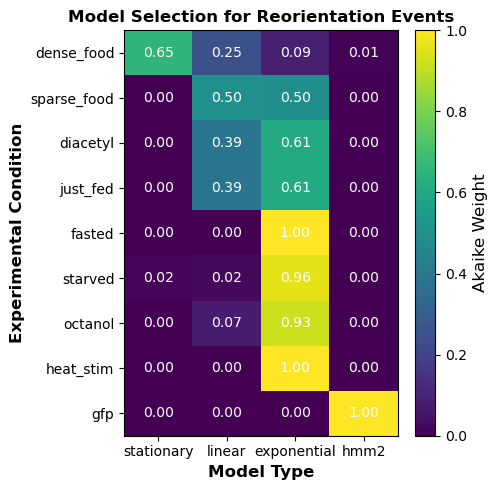

In [79]:
def create_akaike_weights_heatmap(pooled_results, figsize=(5,5)):
    """
    Create heatmap showing Akaike weights for each model in each group (pooled analysis).
    
    Parameters:
    -----------
    pooled_results : dict
        Dictionary with group names as keys and pooled results DataFrames as values
    figsize : tuple
        Figure size
    """
    # Extract Akaike weights from each group
    heatmap_data = {}
    
    for group_name, results_df in pooled_results.items():
        if results_df.empty:
            continue
        
        # Extract Akaike weights (assuming column is named 'Akaike weight')
        akaike_weights = results_df.set_index('Model')['Akaike weight']
        heatmap_data[group_name] = akaike_weights
    
    # Convert to DataFrame
    df = pd.DataFrame(heatmap_data).T.fillna(0)
    
    # Reorder columns to match desired order
    desired_order = ['stationary', 'linear', 'exponential', 'hmm2']
    # Only include columns that exist in the data
    available_columns = [col for col in desired_order if col in df.columns]
    # Add any remaining columns that weren't in the desired order
    remaining_columns = [col for col in df.columns if col not in desired_order]
    final_column_order = available_columns + remaining_columns
    
    df = df[final_column_order]
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df.values, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Akaike Weight', fontsize=12)
    
    # Add text annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            ax.text(j, i, f'{df.values[i, j]:.2f}', ha='center', va='center', color='white')
    
    # Set labels and ticks
    ax.set_xticks(range(df.shape[1]))
    ax.set_yticks(range(df.shape[0]))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    
    ax.set_title('Model Selection for Reorientation Events', fontweight='bold', fontsize=12)
    ax.set_xlabel('Model Type', fontweight='bold', fontsize=12)
    ax.set_ylabel('Experimental Condition', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    return fig

# Usage:
fig = create_akaike_weights_heatmap(pooled_results)
plt.show()

dense_food: stationary model, params: {'lam': 0.03422409751523676}
sparse_food: linear model, params: {'beta0': np.float64(-3.2459419552654993), 'beta1': np.float64(-0.00038860766930666436)}
diacetyl: exponential model, params: {'A': np.float64(0.019529428269070993), 'tau': np.float64(463.0112292243553), 'C': np.float64(0.02002566945604832)}
just_fed: exponential model, params: {'A': np.float64(0.019529428269070993), 'tau': np.float64(463.0112292243553), 'C': np.float64(0.02002566945604832)}
fasted: exponential model, params: {'A': np.float64(0.0323960884143087), 'tau': np.float64(2792.821169007177), 'C': np.float64(1.8187345362575746e-06)}
starved: exponential model, params: {'A': np.float64(0.013401491971657593), 'tau': np.float64(259.1027810444115), 'C': np.float64(0.022875604053998733)}
octanol: exponential model, params: {'A': np.float64(0.022998922609747566), 'tau': np.float64(400.8058243121154), 'C': np.float64(0.014150570443114727)}
gfp: hmm2 model, params: {'lam': array([0.001

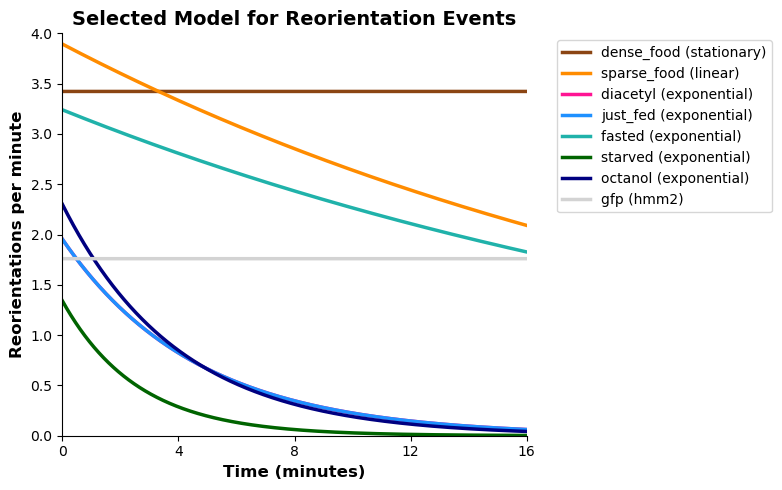

In [116]:
import matplotlib.pyplot as plt
import numpy as np

def plot_event_rates(pooled_results, dict_color, time_range=(0, 1600), time_step=1):
    """
    Plot modeled event rates over time for multiple groups.
    
    Parameters:
    -----------
    pooled_results : dict
        Dictionary containing DataFrames with model results for each group
        Each DataFrame has columns: Model, AIC, Params (where Params contains dict objects)
    dict_color : dict
        Dictionary mapping group names to colors
    time_range : tuple
        (start_time, end_time) for the plot
    time_step : float
        Time step for generating time points
    """
    
    def find_best_model(group_df):
        """Find the model with the lowest AIC for a group DataFrame"""
        # Find the row with the minimum AIC
        min_aic_idx = group_df['AIC'].idxmin()
        best_row = group_df.loc[min_aic_idx]
        
        best_model = best_row['Model']
        best_params = best_row['Params']  # This should already be a dict object
        
        return best_model, best_params
    
    def calculate_event_rate(t, model, params):
        """Calculate event rate per 100 time points based on model"""
        if model == 'stationary':
            rate = params['lam']
        elif model == 'linear':
            rate = np.exp(params['beta0'] + params['beta1'] * t)
        elif model == 'exponential':
            rate = params['A'] * np.exp(-t / params['tau'])
        elif model == 'hmm2':
            # Use average of two states
            rate = (params['lam'][0] + params['lam'][1]) / 2
        else:
            rate = 0
        
        return rate * 100  # Convert to events per 100 time points
    
    # Create time points
    time_points = np.arange(time_range[0], time_range[1] + time_step, time_step)
    
    # Set up the plot
    plt.figure(figsize=(8,5))
    
    # Process each group
    for group_name, group_df in pooled_results.items():
        if group_name not in dict_color:
            continue

        if group_name in ['heat_stim']:
            continue
            
        # Find best model for this group
        best_model, best_params = find_best_model(group_df)
        
        print(f"{group_name}: {best_model} model, params: {best_params}")
        
        # Calculate event rates over time
        event_rates = []
        for t in time_points:
            rate = calculate_event_rate(t, best_model, best_params)
            event_rates.append(rate)
        
        # Plot the line
        color = dict_color[group_name]
        plt.plot(time_points, event_rates, 
                color=color, 
                linewidth=2.5, 
                label=f'{group_name} ({best_model})')
    
    # Customize the plot
    plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    plt.ylabel('Reorientations per minute', fontsize=12, fontweight='bold')
    plt.title('Model Fit for Reorientation Events', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits and custom tick labels
    plt.xlim(0, 1600)
    plt.ylim(0, 4)
    plt.xticks([0, 400, 800, 1200, 1600], [0, 4, 8, 12, 16])
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
        
    return plt

plt = plot_event_rates(pooled_results, dict_color)
plt.show()

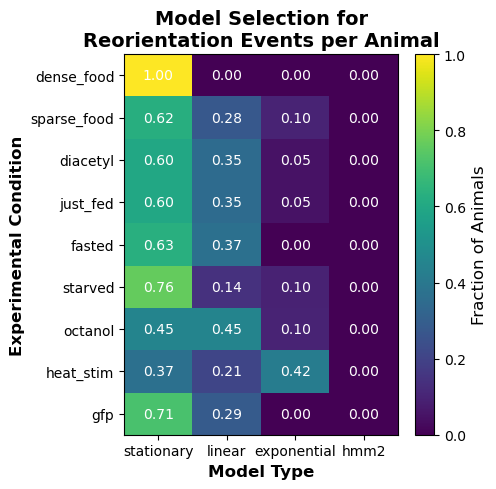

In [160]:
# Heatmap to show which type of model explains the behavior trajectory best at a per animal level

import matplotlib.pyplot as plt

def model_selection_per_animal(per_animal_results, criterion='AIC', figsize=(5, 5)):
    """
    Create heatmap showing fraction of animals in each group best explained by each model.
    
    Parameters:
    -----------
    per_animal_results : dict
        Dictionary with group names as keys and (per_animal_df, summary_df) tuples as values
    criterion : str
        'AIC' or 'BIC' for model selection
    figsize : tuple
        Figure size
    """
    
    # Extract best model for each animal in each group
    heatmap_data = {}
    
    for group_name, per_animal_df in per_animal_results.items():
        if per_animal_df.empty:
            continue
            
        # Find best model per animal
        best_models = per_animal_df.loc[per_animal_df.groupby('animal')[criterion].idxmin()]
        
        # Calculate model fractions
        model_counts = best_models['Model'].value_counts()
        model_fractions = model_counts / len(best_models)
        heatmap_data[group_name] = model_fractions
    
    # Convert to DataFrame
    df = pd.DataFrame(heatmap_data).T.fillna(0)
    
    # Ensure all desired columns are present, even if never selected
    desired_order = ['stationary', 'linear', 'exponential', 'hmm2']
    for col in desired_order:
        if col not in df.columns:
            df[col] = 0.0
    
    # Reorder columns to match desired order
    available_columns = [col for col in desired_order if col in df.columns]
    # Add any remaining columns that weren't in the desired order
    remaining_columns = [col for col in df.columns if col not in desired_order]
    final_column_order = available_columns + remaining_columns
    
    df = df[final_column_order]
    
    # Create heatmap
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.imshow(df.values, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'Fraction of Animals', fontsize=12)
    
    # Add text annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            ax.text(j, i, f'{df.values[i, j]:.2f}', 
                   ha='center', va='center', color='white')
    
    # Set labels and ticks
    ax.set_xticks(range(df.shape[1]))
    ax.set_yticks(range(df.shape[0]))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    
    ax.set_title(f'Model Selection for\nReorientation Events per Animal', fontweight='bold', fontsize=14)
    ax.set_xlabel('Model Type', fontweight='bold', fontsize=12)
    ax.set_ylabel('Experimental Condition', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    return fig

# Usage:
fig = model_selection_per_animal(per_animal_results)
fig.show()

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_per_animal_event_rates(per_animal_results, dict_color, 
                                time_range=(0, 1600), time_step=1):
    """
    Plot modeled event rates over time for individual animals, colored by group.
    
    Parameters:
    -----------
    per_animal_results : dict
        Dictionary where keys are group names and values are DataFrames
        from compare_models_per_animal with columns: 
        animal, Model, AIC, BIC, weight_AIC, weight_BIC, Params
    dict_color : dict
        Dictionary mapping group names to colors
    time_range : tuple
        (start_time, end_time) for the plot
    time_step : float
        Time step for generating time points
    """
    
    def find_best_model_for_animal(animal_df):
        """Find the model with the lowest AIC for a specific animal"""
        min_aic_idx = animal_df['AIC'].idxmin()
        best_row = animal_df.loc[min_aic_idx]
        return best_row['Model'], best_row['Params']
    
    def calculate_event_rate(t, model, params):
        """Calculate event rate per 100 time points based on model"""
        if model == 'stationary':
            rate = params['lam']
        elif model == 'linear':
            rate = np.exp(params['beta0'] + params['beta1'] * t)
        elif model == 'exponential':
            rate = params['A'] * np.exp(-t / params['tau'])
        elif model == 'hmm2':
            # Use average of two states
            rate = (params['lam'][0] + params['lam'][1]) / 2
        else:
            rate = 0
        
        return rate * 100  # Convert to events per 100 time points
    
    # Create time points
    time_points = np.arange(time_range[0], time_range[1] + time_step, time_step)
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Track which groups we've added to legend
    groups_in_legend = set()
    
    # Process each group
    for group_name, group_df in per_animal_results.items():
        # Skip if group not in color dict or is heat_stim
        if group_name not in dict_color or group_name == 'heat_stim':
            continue
        
        # Skip if dataframe is empty
        if group_df.empty:
            continue
        
        color = dict_color[group_name]
        
        # Get unique animals in this group
        unique_animals = group_df['animal'].unique()
        
        # Process each animal in the group
        for i, animal_idx in enumerate(unique_animals):
            # Get this animal's data
            animal_df = group_df[group_df['animal'] == animal_idx]
            
            # Find best model for this animal
            best_model, best_params = find_best_model_for_animal(animal_df)
            
            # Calculate event rates over time
            event_rates = []
            for t in time_points:
                rate = calculate_event_rate(t, best_model, best_params)
                event_rates.append(rate)
            
            # Add label only for first animal of each group
            if group_name not in groups_in_legend:
                label = group_name
                groups_in_legend.add(group_name)
            else:
                label = None
            
            plt.plot(time_points, event_rates, 
                    color=color, 
                    linewidth=1.5,  # Slightly thinner lines since we have many
                    alpha=0.6,  # Some transparency to see overlapping lines
                    label=label)
    
    # Customize the plot
    plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    plt.ylabel('Reorientations per minute', fontsize=12, fontweight='bold')
    plt.title('Per-Animal Model Fits for Reorientation Events', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits and custom tick labels
    plt.xlim(0, 1600)
    plt.ylim(0, 6)  # Might need more range for individual variability
    plt.xticks([0, 400, 800, 1200, 1600], [0, 4, 8, 12, 16])
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return plt


def plot_individual_trajectories(per_animal_results, dict_color, 
                                 time_range=(0, 1600), time_step=10, figsize=(8, 6)):
    """
    Plot individual animal model fits.
    
    Parameters:
    -----------
    per_animal_results : dict
        Dictionary where keys are group names and values are DataFrames
        from compare_models_per_animal
    dict_color : dict
        Dictionary mapping group names to colors
    time_range : tuple
        (start_time, end_time) for the plot
    time_step : float
        Time step for generating time points
    figsize : tuple
        Figure size (width, height)
    """
    
    def find_best_model_for_animal(animal_df):
        """Find the model with the lowest AIC for a specific animal"""
        min_aic_idx = animal_df['AIC'].idxmin()
        best_row = animal_df.loc[min_aic_idx]
        return best_row['Model'], best_row['Params']
    
    def calculate_event_rate(t, model, params):
        """Calculate event rate per 100 time points based on model"""
        if model == 'stationary':
            rate = params['lam']
        elif model == 'linear':
            rate = np.exp(params['beta0'] + params['beta1'] * t)
        elif model == 'exponential':
            rate = params['A'] * np.exp(-t / params['tau'])
        elif model == 'hmm2':
            # Use average of two states
            rate = (params['lam'][0] + params['lam'][1]) / 2
        else:
            rate = 0
        
        return rate * 100  # Convert to events per 100 time points
    
    # Create time points
    time_points = np.arange(time_range[0], time_range[1] + time_step, time_step)
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Collect all trajectories by group
    group_trajectories = {}
    
    for group_name, group_df in per_animal_results.items():
        # Skip if group not in color dict or is heat_stim
        if group_name not in dict_color or group_name == 'heat_stim':
            continue
        
        # Skip if dataframe is empty
        if group_df.empty:
            continue
        
        group_trajectories[group_name] = []
        
        # Get unique animals in this group
        unique_animals = group_df['animal'].unique()
        
        # Process each animal
        for animal_idx in unique_animals:
            # Get this animal's data
            animal_df = group_df[group_df['animal'] == animal_idx]
            
            # Find best model for this animal
            best_model, best_params = find_best_model_for_animal(animal_df)
            
            # Calculate event rates over time
            event_rates = []
            for t in time_points:
                rate = calculate_event_rate(t, best_model, best_params)
                event_rates.append(rate)
            
            group_trajectories[group_name].append(event_rates)
    
    # Plot individual trajectories
    for group_name, trajectories in group_trajectories.items():
        if not trajectories:
            continue
        color = dict_color[group_name]
        for i, traj in enumerate(trajectories):
            label = group_name if i == 0 else None
            ax.plot(time_points, traj, color=color, linewidth=1.5, alpha=0.4, label=label)
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Reorientations per minute', fontsize=12, fontweight='bold')
    ax.set_title('Individual Animal Model Fits', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 6)
    ax.set_xticks([0, 400, 800, 1200, 1600])
    ax.set_xticklabels([0, 4, 8, 12, 16])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return fig, ax


def plot_group_summary_statistics(per_animal_results, dict_color, 
                                  time_range=(0, 1600), time_step=1, figsize=(6, 5)):
    """
    Plot group mean and standard error bands.
    
    Parameters:
    -----------
    per_animal_results : dict
        Dictionary where keys are group names and values are DataFrames
        from compare_models_per_animal
    dict_color : dict
        Dictionary mapping group names to colors
    time_range : tuple
        (start_time, end_time) for the plot
    time_step : float
        Time step for generating time points
    figsize : tuple
        Figure size (width, height)
    """
    
    def find_best_model_for_animal(animal_df):
        """Find the model with the lowest AIC for a specific animal"""
        min_aic_idx = animal_df['AIC'].idxmin()
        best_row = animal_df.loc[min_aic_idx]
        return best_row['Model'], best_row['Params']
    
    def calculate_event_rate(t, model, params):
        """Calculate event rate per 100 time points based on model"""
        if model == 'stationary':
            rate = params['lam']
        elif model == 'linear':
            rate = np.exp(params['beta0'] + params['beta1'] * t)
        elif model == 'exponential':
            rate = params['A'] * np.exp(-t / params['tau'])
        elif model == 'hmm2':
            # Use average of two states
            rate = (params['lam'][0] + params['lam'][1]) / 2
        else:
            rate = 0
        
        return rate * 100  # Convert to events per 100 time points
    
    # Create time points
    time_points = np.arange(time_range[0], time_range[1] + time_step, time_step)
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Collect all trajectories by group
    group_trajectories = {}
    
    for group_name, group_df in per_animal_results.items():
        # Skip if group not in color dict or is heat_stim
        if group_name not in dict_color:
            continue
        
        # Skip if dataframe is empty
        if group_df.empty:
            continue
        
        group_trajectories[group_name] = []
        
        # Get unique animals in this group
        unique_animals = group_df['animal'].unique()
        
        # Process each animal
        for animal_idx in unique_animals:
            # Get this animal's data
            animal_df = group_df[group_df['animal'] == animal_idx]
            
            # Find best model for this animal
            best_model, best_params = find_best_model_for_animal(animal_df)
            
            # Calculate event rates over time
            event_rates = []
            for t in time_points:
                rate = calculate_event_rate(t, best_model, best_params)
                event_rates.append(rate)
            
            group_trajectories[group_name].append(event_rates)
    
    # Plot mean ± SE
    for group_name, trajectories in group_trajectories.items():
        if not trajectories:
            continue
        color = dict_color[group_name]
        trajectories_array = np.array(trajectories)
        mean_traj = np.mean(trajectories_array, axis=0)
        se_traj = np.std(trajectories_array, axis=0) / np.sqrt(len(trajectories))
        
        ax.plot(time_points, mean_traj, color=color, linewidth=3, 
               label=f'{group_name}')
        ax.fill_between(time_points, mean_traj - se_traj, mean_traj + se_traj, 
                        color=color, alpha=0.1)
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Reorientations per minute', fontsize=12, fontweight='bold')
    ax.set_title('Model Fits for Reorientation Events\n(aggregated by experimental condition)\n', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 4.5)
    ax.set_xticks([0, 400, 800, 1200, 1600])
    ax.set_xticklabels([0, 4, 8, 12, 16])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return fig, ax


# Optional: Helper function to create both plots side by side if needed
def plot_both_analyses(per_animal_results, dict_color, 
                       time_range=(0, 1600), time_step=10, figsize=(16, 6)):
    """
    Create both individual trajectories and summary statistics plots side by side.
    
    Returns:
    --------
    fig : matplotlib figure
        Figure containing both subplots
    (ax1, ax2) : tuple of axes
        Individual trajectories axis and summary statistics axis
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Get the individual plot data and apply to ax1
    fig1, temp_ax1 = plot_individual_trajectories(per_animal_results, dict_color, 
                                                  time_range, time_step, figsize=(8, 6))
    plt.close(fig1)  # Close the temporary figure
    
    # Get the summary plot data and apply to ax2  
    fig2, temp_ax2 = plot_group_summary_statistics(per_animal_results, dict_color, 
                                                   time_range, time_step, figsize=(8, 6))
    plt.close(fig2)  # Close the temporary figure
    
    # You would need to manually recreate the plotting logic here for ax1 and ax2
    # This is a simplified version - you'd want to extract the core plotting logic
    # into helper functions to avoid code duplication
    
    plt.tight_layout()
    return fig, (ax1, ax2)

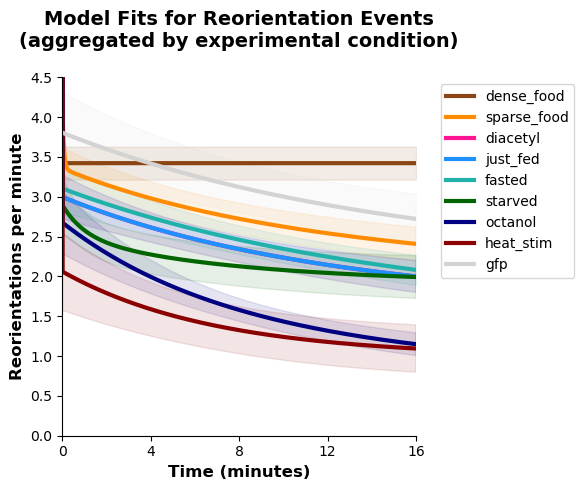

In [172]:
# Simple plot with all individual trajectories:
# plt = plot_per_animal_event_rates(per_animal_results, dict_color)
# plt.show()

# Plot with both individual trajectories and group summaries:
plt = plot_group_summary_statistics(per_animal_results, dict_color)

# Print summary of best models:
# summarize_best_models(per_animal_results)

## Gaussian random process -- frequentist optimization for speed and pumping rate over time

In [43]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple, Optional
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import norm
import warnings

# =========================
# Data prep - MODIFIED for continuous data
# =========================

def prep_continuous_data(series: np.ndarray, t: np.ndarray | None = None
                        ) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray]]:
    """
    series: (n_animals, T) array with continuous values and NaN padding after last observed point
    Returns:
      flat_y, flat_t: pooled vectors over all animals
      seqs: list of per-animal 1D arrays (for HMM and per-animal fits)
    """
    n_animals, T = series.shape
    if t is None:
        t = np.arange(T, dtype=float)
    flat_y, flat_t, seqs = [], [], []
    for i in range(n_animals):
        mask = ~np.isnan(series[i])
        y_i = series[i, mask]  # CHANGED: No need to convert to int
        if y_i.size == 0:
            continue
        t_i = t[mask]
        flat_y.append(y_i); flat_t.append(t_i); seqs.append(y_i)
    return (np.concatenate(flat_y) if flat_y else np.array([], float),  # CHANGED: float instead of int
            np.concatenate(flat_t) if flat_t else np.array([], float),
            seqs)

# CHANGED: Normal log-likelihood
def normal_loglik(y: np.ndarray, mu: np.ndarray, sigma: float) -> float:
    """
    Log-likelihood for normal distribution
    y: observed values
    mu: mean values (can vary over time)
    sigma: standard deviation (assumed constant)
    """
    eps = 1e-12
    sigma = max(sigma, eps)  # Prevent division by zero
    
    try:
        # Use scipy.stats.norm for numerical stability
        ll = np.sum(norm.logpdf(y, loc=mu, scale=sigma))
        if np.isnan(ll) or np.isinf(ll):
            return -np.inf
        return ll
    except:
        return -np.inf

def aic(loglik: float, k: int) -> float:
    return 2 * k - 2 * loglik

def bic(loglik: float, k: int, n_obs: int) -> float:
    return k * np.log(max(n_obs, 1)) - 2 * loglik

# =========================
# Models - MODIFIED for continuous distributions
# =========================

@dataclass
class FitResult:
    name: str
    loglik: float
    k: int
    n_obs: int
    params: Dict[str, Any]
    converged: bool = True
    n_iter: int = 0

# --- Stationary - CHANGED to fit normal distribution ---
def fit_stationary(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("stationary", -np.inf, 2, 0, {})  # CHANGED: k=2 for mu and sigma
    
    mu_hat = float(np.mean(y))
    sigma_hat = float(np.std(y, ddof=1)) if y.size > 1 else 1.0
    sigma_hat = max(sigma_hat, 1e-6)  # Prevent zero variance
    
    ll = normal_loglik(y, np.full_like(y, mu_hat), sigma_hat)
    return FitResult("stationary", ll, 2, y.size, {"mu": mu_hat, "sigma": sigma_hat})

# --- Linear drift - CHANGED to fit normal with linear mean ---
def fit_linear(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("linear", -np.inf, 3, 0, {})  # CHANGED: k=3 for beta0, beta1, sigma
    
    def nll(par):
        b0, b1, log_sigma = par
        sigma = np.exp(log_sigma)  # Ensure sigma > 0
        sigma = np.clip(sigma, 1e-6, 1e6)
        
        mu = b0 + b1 * t  # CHANGED: Direct linear relationship, no exp()
        
        ll = normal_loglik(y, mu, sigma)
        if np.isnan(ll) or np.isinf(ll):
            return 1e10
        return -ll
    
    # Better initialization using linear regression
    if len(y) >= 2:
        coeffs = np.polyfit(t, y, 1)
        b1_init, b0_init = coeffs
        sigma_init = np.std(y - (b0_init + b1_init * t))
    else:
        b0_init, b1_init = np.mean(y), 0.0
        sigma_init = 1.0
    
    sigma_init = max(sigma_init, 1e-6)
    init = [b0_init, b1_init, np.log(sigma_init)]
    
    bounds = [(-1e6, 1e6), (-1e6, 1e6), (-10, 10)]  # CHANGED: More reasonable bounds
    
    try:
        res = minimize(nll, init, method="L-BFGS-B", bounds=bounds)
        b0, b1, log_sigma = res.x
        sigma = np.exp(log_sigma)
        final_ll = -res.fun if res.success else -1e10
    except:
        b0, b1, log_sigma = init
        sigma = np.exp(log_sigma)
        final_ll = -nll(init)
    
    return FitResult("linear", final_ll, 3, y.size, {"beta0": b0, "beta1": b1, "sigma": sigma})

# --- Exponential drift - CHANGED to fit normal with exponential mean ---
def fit_exponential(y: np.ndarray, t: np.ndarray) -> FitResult:
    if y.size == 0:
        return FitResult("exponential", -np.inf, 4, 0, {})  # CHANGED: k=4 for A, tau, C, sigma
    
    def nll(par):
        log_a, log_tau, c, log_sigma = par
        A = np.exp(np.clip(log_a, -20, 20))
        tau = np.exp(np.clip(log_tau, -10, 10))
        sigma = np.exp(np.clip(log_sigma, -10, 10))
        
        tau = np.clip(tau, 1e-6, 1e6)
        sigma = np.clip(sigma, 1e-6, 1e6)
        
        with np.errstate(over='ignore', invalid='ignore'):
            mu = A * np.exp(-t / tau) + c  # CHANGED: This is now the mean, not lambda
        
        ll = normal_loglik(y, mu, sigma)
        if np.isnan(ll) or np.isinf(ll):
            return 1e10
        return -ll
    
    mean_y = np.mean(y)
    t_range = max((t.max() - t.min()), 1.0)
    sigma_init = max(np.std(y), 1e-6)
    
    # CHANGED: Initialize based on data range
    init = [np.log(abs(mean_y - np.min(y)) + 1e-6), np.log(t_range/3), np.min(y), np.log(sigma_init)]
    bounds = [(-20, 20), (-10, 10), (-1e6, 1e6), (-10, 10)]
    
    try:
        res = minimize(nll, init, method="L-BFGS-B", bounds=bounds)
        log_a, log_tau, c, log_sigma = res.x
        A, tau, sigma = np.exp(log_a), np.exp(log_tau), np.exp(log_sigma)
        final_ll = -res.fun if res.success else -1e10
    except:
        log_a, log_tau, c, log_sigma = init
        A, tau, sigma = np.exp(log_a), np.exp(log_tau), np.exp(log_sigma)
        final_ll = -nll(init)
    
    return FitResult("exponential", final_ll, 4, y.size, {"A": A, "tau": tau, "C": c, "sigma": sigma})

# --- Two-state Normal HMM - MAJOR CHANGES for continuous data ---
def fb_normal_stable(y: np.ndarray, mu: np.ndarray, sigma: np.ndarray, A: np.ndarray, pi: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Forward-backward algorithm for Normal HMM (instead of Poisson).
    
    CHANGED: Now uses normal emission probabilities instead of Poisson
    """
    T = len(y)
    S = len(mu)
    
    # Compute emission probabilities in log space
    # CHANGED: Use normal log-pdf instead of Poisson
    sigma_safe = np.maximum(sigma, 1e-10)
    log_b = np.zeros((T, S))
    for k in range(S):
        log_b[:, k] = norm.logpdf(y, loc=mu[k], scale=sigma_safe[k])
    
    # Forward pass in log space
    log_alpha = np.zeros((T, S))
    log_alpha[0] = np.log(pi + 1e-300) + log_b[0]
    
    for t in range(1, T):
        for j in range(S):
            log_alpha[t, j] = logsumexp(log_alpha[t-1] + np.log(A[:, j] + 1e-300)) + log_b[t, j]
    
    ll = logsumexp(log_alpha[-1])
    
    # Backward pass in log space
    log_beta = np.zeros((T, S))
    log_beta[-1] = 0
    
    for t in range(T-2, -1, -1):
        for i in range(S):
            log_beta[t, i] = logsumexp(np.log(A[i, :] + 1e-300) + log_b[t+1] + log_beta[t+1])
    
    # Compute gamma (state posteriors)
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)
    
    # Compute xi (transition posteriors)
    xi = np.zeros((T-1, S, S))
    for t in range(T-1):
        log_xi_t = np.zeros((S, S))
        for i in range(S):
            for j in range(S):
                log_xi_t[i, j] = (log_alpha[t, i] + np.log(A[i, j] + 1e-300) + 
                                  log_b[t+1, j] + log_beta[t+1, j])
        log_xi_t -= logsumexp(log_xi_t)
        xi[t] = np.exp(log_xi_t)
    
    return ll, gamma, xi

def initialize_normal_parameters(seqs: List[np.ndarray], 
                                low_transition: bool = True,
                                transition_prob: float = 0.01) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    CHANGED: Initialize parameters for Normal HMM instead of Poisson HMM
    """
    y_all = np.concatenate(seqs)
    
    # Use k-means style initialization for mean and variance
    percentiles = np.percentile(y_all, [25, 75])
    
    # Initialize means based on data distribution
    low_mask = y_all <= percentiles[0]
    high_mask = y_all >= percentiles[1]
    
    if low_mask.sum() > 0:
        mu_low = y_all[low_mask].mean()
        sigma_low = max(y_all[low_mask].std(), 1e-6)
    else:
        mu_low = y_all.mean() - y_all.std()
        sigma_low = y_all.std() * 0.5
    
    if high_mask.sum() > 0:
        mu_high = y_all[high_mask].mean()
        sigma_high = max(y_all[high_mask].std(), 1e-6)
    else:
        mu_high = y_all.mean() + y_all.std()
        sigma_high = y_all.std() * 0.5
    
    # CHANGED: Return means and standard deviations instead of lambda rates
    mu = np.array([mu_low, mu_high])
    sigma = np.array([max(sigma_low, 1e-6), max(sigma_high, 1e-6)])
    
    # Initialize transition matrix (same as before)
    if low_transition:
        diag_prob = 1 - transition_prob
        A = np.array([[diag_prob, transition_prob],
                      [transition_prob, diag_prob]])
    else:
        A = np.array([[0.9, 0.1],
                      [0.1, 0.9]])
    
    pi = np.array([0.5, 0.5])
    
    return mu, sigma, A, pi

def fit_hmm2(seqs: List[np.ndarray], 
             max_iter: int = 200,
             tol: float = 1e-5,
             low_transition: bool = True,
             transition_prob: Optional[float] = None,
             fix_transition: bool = False,
             verbose: bool = False) -> FitResult:
    """
    CHANGED: Fit 2-state Normal HMM instead of Poisson HMM
    """
    if len(seqs) == 0:
        return FitResult("hmm2", -np.inf, 7, 0, {}, False, 0)  # CHANGED: k=7 (2 means + 2 sigmas + 2 transitions + 1 initial)
    
    if transition_prob is None:
        transition_prob = 0.01 if low_transition else 0.1
    
    # CHANGED: Initialize Normal HMM parameters
    mu, sigma, A, pi = initialize_normal_parameters(seqs, low_transition, transition_prob)
    
    if verbose:
        print(f"Initial parameters:")
        print(f"  Mu: {mu}")
        print(f"  Sigma: {sigma}")
        print(f"  A: {A}")
        print(f"  Pi: {pi}")
    
    prev_ll = -np.inf
    converged = False
    
    for iter_num in range(max_iter):    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df.values, cmap='YlOrRd', vmin=0, vmax=1, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'Fraction Best Fit ({criterion})')
    
    # Add text annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            ax.text(j, i, f'{df.values[i, j]:.2f}', 
                   ha='center', va='center', color='black')
    
    # Set labels and ticks
    ax.set_xticks(range(df.shape[1]))
    ax.set_yticks(range(df.shape[0]))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    
    ax.set_title(f'Model Selection by Group ({criterion})')
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Group')
    
    plt.tight_layout()
    return fig
        # E-step: accumulate sufficient statistics
        sum_xi = np.zeros_like(A)
        sum_gamma = np.zeros(2)
        sum_gamma_y = np.zeros(2)      # CHANGED: For computing means
        sum_gamma_y2 = np.zeros(2)     # CHANGED: For computing variances
        sum_gamma0 = np.zeros(2)
        ll_tot = 0.0
        
        for y in seqs:
            try:
                # CHANGED: Use Normal forward-backward instead of Poisson
                ll, gamma, xi = fb_normal_stable(y, mu, sigma, A, pi)
                
                if np.isnan(ll) or np.isinf(ll):
                    warnings.warn(f"Numerical issue detected at iteration {iter_num}")
                    break
                
                ll_tot += ll
                sum_xi += xi.sum(0)
                sum_gamma += gamma.sum(0)
                sum_gamma_y += gamma.T @ y        # CHANGED: Sum of weighted observations
                sum_gamma_y2 += gamma.T @ (y**2)  # CHANGED: Sum of weighted squared observations
                sum_gamma0 += gamma[0]
                
            except Exception as e:
                warnings.warn(f"Error in forward-backward at iteration {iter_num}: {e}")
                break
        
        # M-step: update parameters
        eps = 1e-10
        
        # CHANGED: Update means and variances instead of lambda rates
        mu_new = sum_gamma_y / np.maximum(sum_gamma, eps)
        
        # Compute variances using the formula: Var = E[X²] - E[X]²
        var_new = (sum_gamma_y2 / np.maximum(sum_gamma, eps)) - mu_new**2
        sigma_new = np.sqrt(np.maximum(var_new, 1e-12))  # Prevent negative/zero variance
        
        # Ensure proper ordering (helps with identifiability)
        if mu_new[0] > mu_new[1]:
            mu_new = mu_new[::-1]
            sigma_new = sigma_new[::-1]
            sum_xi = sum_xi[::-1, ::-1]
            sum_gamma = sum_gamma[::-1]
            sum_gamma0 = sum_gamma0[::-1]
        
        mu = mu_new
        sigma = sigma_new
        
        # Update transition matrix (same as before)
        if not fix_transition:
            A_new = sum_xi / np.maximum(sum_xi.sum(1, keepdims=True), eps)
            
            if low_transition:
                alpha_diag = 100.0
                alpha_off = 1.0
                prior = np.array([[alpha_diag, alpha_off],
                                  [alpha_off, alpha_diag]])
                A_new = (sum_xi + prior) / np.maximum((sum_xi + prior).sum(1, keepdims=True), eps)
            
            A = A_new
        
        # Update initial distribution
        pi = sum_gamma0 / np.maximum(sum_gamma0.sum(), eps)
        
        # Check convergence
        rel_change = abs(ll_tot - prev_ll) / (1 + abs(ll_tot))
        
        if verbose and iter_num % 10 == 0:
            print(f"Iteration {iter_num}: LL = {ll_tot:.4f}, Rel. change = {rel_change:.6f}")
            print(f"  Mu: {mu}")
            print(f"  Sigma: {sigma}")
            print(f"  A diagonal: {np.diag(A)}")
        
        if rel_change < tol:
            converged = True
            if verbose:
                print(f"Converged after {iter_num + 1} iterations")
            break
        
        prev_ll = ll_tot
    
    if not converged and verbose:
        print(f"Did not converge after {max_iter} iterations")
    
    n_obs = sum(len(seq) for seq in seqs)
    n_params = 7  # CHANGED: 2 means + 2 sigmas + 2 transition probs + 1 initial prob
    
    return FitResult(
        name="hmm2",
        loglik=prev_ll,
        k=n_params,
        n_obs=n_obs,
        params={"mu": mu, "sigma": sigma, "A": A, "pi": pi},  # CHANGED: mu/sigma instead of lam
        converged=converged,
        n_iter=iter_num + 1
    )

def decode_states(y: np.ndarray, mu: np.ndarray, sigma: np.ndarray, A: np.ndarray, pi: np.ndarray) -> np.ndarray:
    """
    CHANGED: Viterbi decoding for Normal HMM instead of Poisson HMM
    """
    T = len(y)
    S = len(mu)
    
    # CHANGED: Compute normal emission probabilities in log space
    sigma_safe = np.maximum(sigma, 1e-10)
    log_b = np.zeros((T, S))
    for k in range(S):
        log_b[:, k] = norm.logpdf(y, loc=mu[k], scale=sigma_safe[k])
    
    # Viterbi algorithm in log space (same as before)
    log_delta = np.zeros((T, S))
    psi = np.zeros((T, S), dtype=int)
    
    log_delta[0] = np.log(pi + 1e-300) + log_b[0]
    
    for t in range(1, T):
        for j in range(S):
            temp = log_delta[t-1] + np.log(A[:, j] + 1e-300)
            psi[t, j] = np.argmax(temp)
            log_delta[t, j] = temp[psi[t, j]] + log_b[t, j]
    
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(log_delta[-1])
    
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    
    return states

# =========================
# Core comparison utilities - CHANGED function names and calls
# =========================

def _assemble_table(results: List[FitResult]) -> pd.DataFrame:
    df = pd.DataFrame([{
        "Model": r.name,
        "loglik": r.loglik,
        "k": r.k,
        "n_obs": r.n_obs,
        "AIC": aic(r.loglik, r.k),
        "Params": r.params
    } for r in results]).sort_values("AIC").reset_index(drop=True)

    # ΔAIC / Akaike weights
    min_aic = df["AIC"].min()
    df["ΔAIC"] = df["AIC"] - min_aic
    w = np.exp(-0.5 * df["ΔAIC"])
    df["Akaike weight"] = (w / w.sum()).values

    return df

def compare_models_pooled(series: np.ndarray, t: np.ndarray | None = None) -> pd.DataFrame:
    """
    CHANGED: Now works with continuous series instead of discrete events
    """
    y, tvec, seqs = prep_continuous_data(series, t)  # CHANGED: Use prep_continuous_data
    results = [
        fit_stationary(y, tvec),
        fit_linear(y, tvec),
        fit_exponential(y, tvec),
        fit_hmm2(seqs),
    ]
    return _assemble_table(results)

# =========================
# Per-animal fitting & summary - CHANGED function names
# =========================

def compare_models_per_animal(series: np.ndarray, t: np.ndarray | None = None
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    CHANGED: Now works with continuous series instead of discrete events
    """
    n_animals = series.shape[0]
    if t is None:
        t = np.arange(series.shape[1], dtype=float)

    all_rows = []
    for i in range(n_animals):
        single_animal_series = series[i:i+1]  # CHANGED: series instead of events
        y_i, t_i, seqs_i = prep_continuous_data(single_animal_series, t)  # CHANGED: Use prep_continuous_data
        
        if len(seqs_i) == 0 or y_i.size == 0:
            continue
            
        res = [
            fit_stationary(y_i, t_i),
            fit_linear(y_i, t_i),
            fit_exponential(y_i, t_i),
            fit_hmm2(seqs_i),
        ]
        df_i = _assemble_table(res)
        df_i.insert(0, "animal", i)
        all_rows.append(df_i)

    per_animal_df = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

    if per_animal_df.empty:
        summary_df = pd.DataFrame(columns=["Criterion", "Model", "Wins"])
        return per_animal_df, summary_df

    winners_aic = (per_animal_df.loc[per_animal_df.groupby("animal")["AIC"].idxmin(), ["animal","Model"]]
                   .value_counts("Model").rename_axis("Model").reset_index(name="Wins"))

    winners_aic.insert(0, "Criterion", "AIC")
    summary_df = pd.concat([winners_aic], ignore_index=True)
    summary_df = summary_df.sort_values(["Criterion","Wins"], ascending=[True, False]).reset_index(drop=True)
    return per_animal_df, summary_df

# =========================
# Convenience wrapper - CHANGED parameter names
# =========================

def compare_models(series: np.ndarray, t: np.ndarray | None = None, mode: str = "pooled"):
    """
    CHANGED: Now works with continuous series instead of discrete events
    mode: "pooled" -> pooled table only
          "per_animal" -> (per_animal_df, summary_df)
    """
    if mode == "pooled":
        return compare_models_pooled(series, t)
    elif mode == "per_animal":
        return compare_models_per_animal(series, t)
    else:
        raise ValueError("mode must be 'pooled' or 'per_animal'")

In [48]:
# Initialize dictionaries to store results for each group
pooled_results = {}
per_animal_results = {}
summary_results = {}

# Analyze each group and store results
for group in groups:
    events = all_pumping_rates[group]
    
    print(f"\n{'='*60}")
    print(f"GROUP: {group}")
    print(f"{'='*60}")
    
    # Pooled across animals
    pooled_df = compare_models(events, t=None, mode="pooled")
    pooled_results[group] = pooled_df
    
    print("\nPooled Analysis:")
    print(pooled_df.to_string(index=False))
    
    # Per-animal fits + winner summary
    per_animal_df, summary_df = compare_models(events, t=None, mode="per_animal")
    per_animal_results[group] = per_animal_df
    summary_results[group] = summary_df
    
    print("\nPer-Animal Winner Summary:")
    print(summary_df.to_string(index=False))

# Now you can access results later like:
# pooled_results['group_name'] - pooled model comparison table
# per_animal_results['group_name'] - detailed per-animal results
# summary_results['group_name'] - winner counts

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE - Results stored in dictionaries")
print(f"{'='*60}")
print(f"Groups analyzed: {list(pooled_results.keys())}")
print(f"Access results using:")
print(f"  - pooled_results['group_name']")
print(f"  - per_animal_results['group_name'] ")
print(f"  - summary_results['group_name']")

# Example of accessing stored results:
# print("\nExample - accessing first group's pooled results:")
# first_group = list(groups)[0]
# print(f"Best model for {first_group}:")
# best_model = pooled_results[first_group].iloc[0]
# print(f"  Model: {best_model['Model']}")
# print(f"  AIC: {best_model['AIC']:.2f}")
# print(f"  Akaike weight: {best_model['Akaike weight']:.3f}")


GROUP: dense_food

Pooled Analysis:
      Model        loglik  k  n_obs          AIC                                                                                                                                                                                                                                              Params         ΔAIC  Akaike weight
       hmm2  -5478.294894  7   6399 10970.589787 {'mu': [1.8220156982124627, 4.211807378791565], 'sigma': [1.2743485402834678, 0.35840080818679343], 'A': [[0.9933624048150222, 0.0066375951849777575], [0.004292025572588421, 0.9957079744274115]], 'pi': [0.12506940834329405, 0.874930591656706]}     0.000000            1.0
exponential -10606.840317  4   6399 21221.680634                                                                                                                                          {'A': 5.365763225499516, 'tau': 1728.6776896567387, 'C': -0.9131510337312914, 'sigma': 1.2695386111773124} 10251.090846            0.0


In [49]:
# Save your dictionaries
base_path = "./pump_gaussian_20250827"
save_results_to_pickle(pooled_results, per_animal_results, summary_results, base_path)

Saved pooled_results to ./pump_gaussian_20250827_pooled.pkl
Saved per_animal_results to ./pump_gaussian_20250827_per_animal.pkl
Saved summary_results to ./pump_gaussian_20250827_summary.pkl


In [50]:
# Initialize dictionaries to store results for each group
pooled_results = {}
per_animal_results = {}
summary_results = {}

# Analyze each group and store results
for group in groups:
    events = all_speeds[group]
    
    print(f"\n{'='*60}")
    print(f"GROUP: {group}")
    print(f"{'='*60}")
    
    # Pooled across animals
    pooled_df = compare_models(events, t=None, mode="pooled")
    pooled_results[group] = pooled_df
    
    print("\nPooled Analysis:")
    print(pooled_df.to_string(index=False))
    
    # Per-animal fits + winner summary
    per_animal_df, summary_df = compare_models(events, t=None, mode="per_animal")
    per_animal_results[group] = per_animal_df
    summary_results[group] = summary_df
    
    print("\nPer-Animal Winner Summary:")
    print(summary_df.to_string(index=False))

# Now you can access results later like:
# pooled_results['group_name'] - pooled model comparison table
# per_animal_results['group_name'] - detailed per-animal results
# summary_results['group_name'] - winner counts

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE - Results stored in dictionaries")
print(f"{'='*60}")
print(f"Groups analyzed: {list(pooled_results.keys())}")
print(f"Access results using:")
print(f"  - pooled_results['group_name']")
print(f"  - per_animal_results['group_name'] ")
print(f"  - summary_results['group_name']")

# Example of accessing stored results:
# print("\nExample - accessing first group's pooled results:")
# first_group = list(groups)[0]
# print(f"Best model for {first_group}:")
# best_model = pooled_results[first_group].iloc[0]
# print(f"  Model: {best_model['Model']}")
# print(f"  AIC: {best_model['AIC']:.2f}")
# print(f"  Akaike weight: {best_model['Akaike weight']:.3f}")


GROUP: dense_food

Pooled Analysis:
      Model       loglik  k  n_obs           AIC                                                                                                                                                                                                                                                    Params         ΔAIC  Akaike weight
       hmm2 21435.116124  7   6399 -42856.232248 {'mu': [0.001464331983645288, 0.028362974794101416], 'sigma': [0.0017515677592328963, 0.02689897805768367], 'A': [[0.8848137794927673, 0.11518622050723268], [0.13172984170603524, 0.8682701582939648]], 'pi': [0.49608176464661036, 0.5039182353533896]}     0.000000            1.0
     linear 15315.076362  3   6399 -30624.152725                                                                                                                                                           {'beta0': 0.004528023099428062, 'beta1': 2.3644819857954254e-05, 'sigma': 0.022097447463733006} 12232.0795

KeyboardInterrupt: 

In [ ]:
# Save your dictionaries
base_path = "./speed_gaussian_20250827"
save_results_to_pickle(pooled_results, per_animal_results, summary_results, base_path)

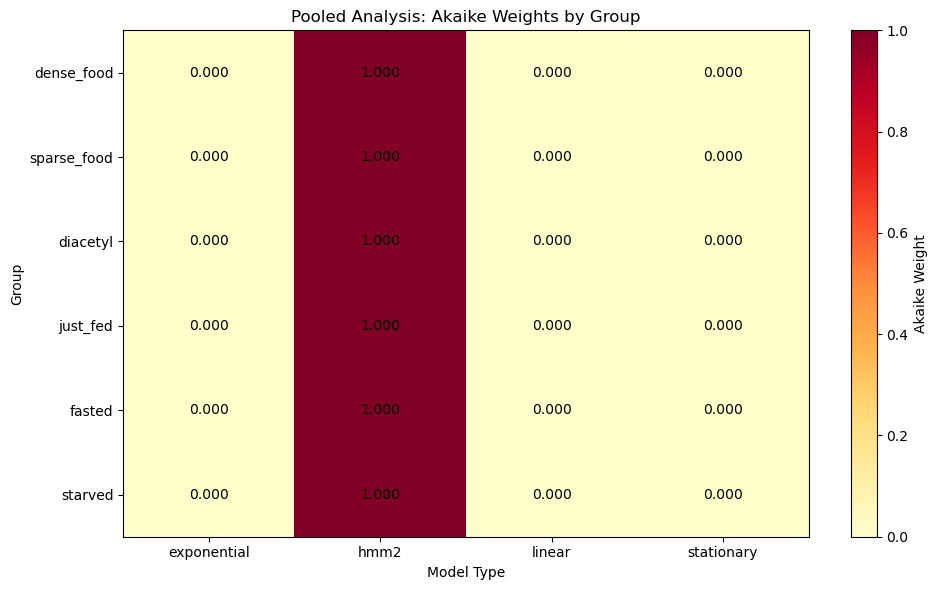

In [51]:
# Heatmap to show which type of model explains the behavior trajectory best at the pooled level by Akaike weight
fig = create_akaike_weights_heatmap(pooled_results)
plt.show()

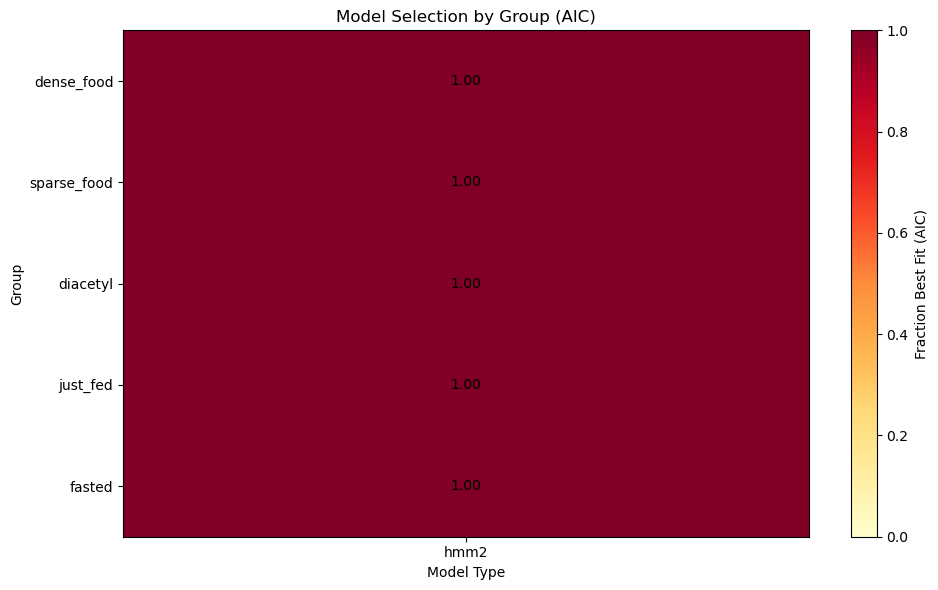

In [52]:
# Heatmap to show which type of model explains the behavior trajectory best at a per animal level
fig = create_model_selection_heatmap(per_animal_results)
plt.show()

In [55]:
def extract_model_params(per_animal_results, group_name, animal_id):
    """
    Extract HMM and linear model parameters for a specific animal from per_animal_results.
    
    Parameters:
    -----------
    per_animal_results : dict
        Dictionary with group names as keys and (per_animal_df, summary_df) tuples as values
    group_name : str
        Name of the group (key in per_animal_results)
    animal_id : int
        Animal ID to extract parameters for
        
    Returns:
    --------
    tuple
        (hmm_params, linear_params) or (None, None) if not found
    """
    
    if group_name not in per_animal_results:
        print(f"Group '{group_name}' not found in results")
        return None, None
    
    per_animal_df = per_animal_results[group_name]
    
    # Filter for the specific animal
    animal_data = per_animal_df[per_animal_df['animal'] == animal_id]
    
    if animal_data.empty:
        print(f"Animal {animal_id} not found in group '{group_name}'")
        return None, None
    
    # Extract HMM parameters
    hmm_row = animal_data[animal_data['Model'] == 'hmm2']
    hmm_params = None
    if not hmm_row.empty:
        hmm_params = hmm_row.iloc[0]['Params']
    
    # Extract Linear parameters  
    linear_row = animal_data[animal_data['Model'] == 'linear']
    linear_params = None
    if not linear_row.empty:
        linear_params = linear_row.iloc[0]['Params']
    
    return hmm_params, linear_params

def extract_pooled_model_params(pooled_results, group_name):
    """
    Extract HMM and linear model parameters from pooled results.
    
    Parameters:
    -----------
    pooled_results : dict
        Dictionary with group names as keys and results DataFrames as values
    group_name : str
        Name of the group
        
    Returns:
    --------
    tuple
        (hmm_params, linear_params) or (None, None) if not found
    """
    
    if group_name not in pooled_results:
        print(f"Group '{group_name}' not found in pooled results")
        return None, None
    
    results_df = pooled_results[group_name]
    
    # Extract HMM parameters
    hmm_row = results_df[results_df['Model'] == 'hmm2']
    hmm_params = hmm_row.iloc[0]['Params'] if not hmm_row.empty else None
    
    # Extract Linear parameters
    linear_row = results_df[results_df['Model'] == 'linear']  
    linear_params = linear_row.iloc[0]['Params'] if not linear_row.empty else None
    
    return hmm_params, linear_params


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def diagnose_hmm_vs_linear(y, t, hmm_params, linear_params):
    """
    Diagnostic plots to understand why HMM2 might be beating linear model
    
    Parameters:
    -----------
    y : array
        Continuous time series data
    t : array  
        Time points
    hmm_params : dict
        HMM parameters with keys: 'mu', 'sigma', 'A', 'pi'
    linear_params : dict
        Linear parameters with keys: 'beta0', 'beta1', 'sigma'
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Raw data with both fits
    ax = axes[0, 0]
    ax.scatter(t, y, alpha=0.6, s=20, color='gray', label='Data')
    
    # Linear fit
    linear_fit = linear_params['beta0'] + linear_params['beta1'] * t
    ax.plot(t, linear_fit, 'b-', linewidth=2, label='Linear Model')
    
    # HMM decode states and show means
    states = decode_states(y, hmm_params['mu'], hmm_params['sigma'], 
                          hmm_params['A'], hmm_params['pi'])
    
    # Color points by HMM state
    state_colors = ['red', 'orange']
    for state in range(2):
        mask = states == state
        if mask.any():
            ax.scatter(t[mask], y[mask], c=state_colors[state], s=30, 
                      label=f'HMM State {state} (μ={hmm_params["mu"][state]:.2f})')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title('Data with Model Fits')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Residuals from linear model
    ax = axes[0, 1]
    linear_residuals = y - linear_fit
    ax.scatter(t, linear_residuals, alpha=0.6, color='blue')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    ax.set_title('Linear Model Residuals')
    ax.grid(True, alpha=0.3)
    
    # Check for heteroskedasticity (changing variance)
    residual_std = np.std(linear_residuals)
    ax.axhline(y=2*residual_std, color='red', linestyle=':', alpha=0.7, label='±2σ')
    ax.axhline(y=-2*residual_std, color='red', linestyle=':', alpha=0.7)
    ax.legend()
    
    # 3. Variance over time (sliding window)
    ax = axes[1, 0]
    window_size = max(10, len(y) // 10)
    if len(y) >= window_size * 2:
        rolling_var = []
        rolling_t = []
        for i in range(window_size, len(y) - window_size):
            window_data = linear_residuals[i-window_size:i+window_size]
            rolling_var.append(np.var(window_data))
            rolling_t.append(t[i])
        
        ax.plot(rolling_t, rolling_var, 'g-', linewidth=2)
        ax.axhline(y=linear_params['sigma']**2, color='blue', linestyle='--', 
                  label=f'Linear Model σ² = {linear_params["sigma"]**2:.3f}')
        
        # Show HMM variances
        for state in range(2):
            ax.axhline(y=hmm_params['sigma'][state]**2, color=state_colors[state], 
                      linestyle=':', label=f'HMM State {state} σ² = {hmm_params["sigma"][state]**2:.3f}')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Variance')
    ax.set_title('Variance Over Time (Sliding Window)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Q-Q plot for normality of residuals
    ax = axes[1, 1]
    stats.probplot(linear_residuals, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot: Linear Model Residuals')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("=== DIAGNOSTIC SUMMARY ===")
    print(f"Linear Model:")
    print(f"  Residual std: {np.std(linear_residuals):.4f}")
    print(f"  Assumed σ: {linear_params['sigma']:.4f}")
    print(f"  R²: {1 - np.var(linear_residuals) / np.var(y):.4f}")
    
    print(f"\nHMM Model:")
    print(f"  State 0: μ={hmm_params['mu'][0]:.3f}, σ={hmm_params['sigma'][0]:.3f}")
    print(f"  State 1: μ={hmm_params['mu'][1]:.3f}, σ={hmm_params['sigma'][1]:.3f}")
    print(f"  Transition probs: {hmm_params['A'][0,1]:.3f}, {hmm_params['A'][1,0]:.3f}")
    
    # Test for heteroskedasticity
    if len(y) > 20:
        # Simple test: correlation between absolute residuals and time
        het_corr = np.corrcoef(t, np.abs(linear_residuals))[0,1]
        print(f"\nHeteroskedasticity test:")
        print(f"  Correlation(time, |residuals|): {het_corr:.3f}")
        if abs(het_corr) > 0.3:
            print("  → Evidence of changing variance over time!")
        else:
            print("  → Variance appears roughly constant")
    
    return fig

# Usage after fitting both models:
# diagnose_hmm_vs_linear(y, t, hmm_result.params, linear_result.params)

=== DIAGNOSTIC SUMMARY ===
Linear Model:
  Residual std: 0.0346
  Assumed σ: 0.0346
  R²: 0.0280

HMM Model:
  State 0: μ=0.049, σ=0.026
  State 1: μ=0.102, σ=0.022
  Transition probs: 0.130, 0.111

Heteroskedasticity test:
  Correlation(time, |residuals|): -0.042
  → Variance appears roughly constant


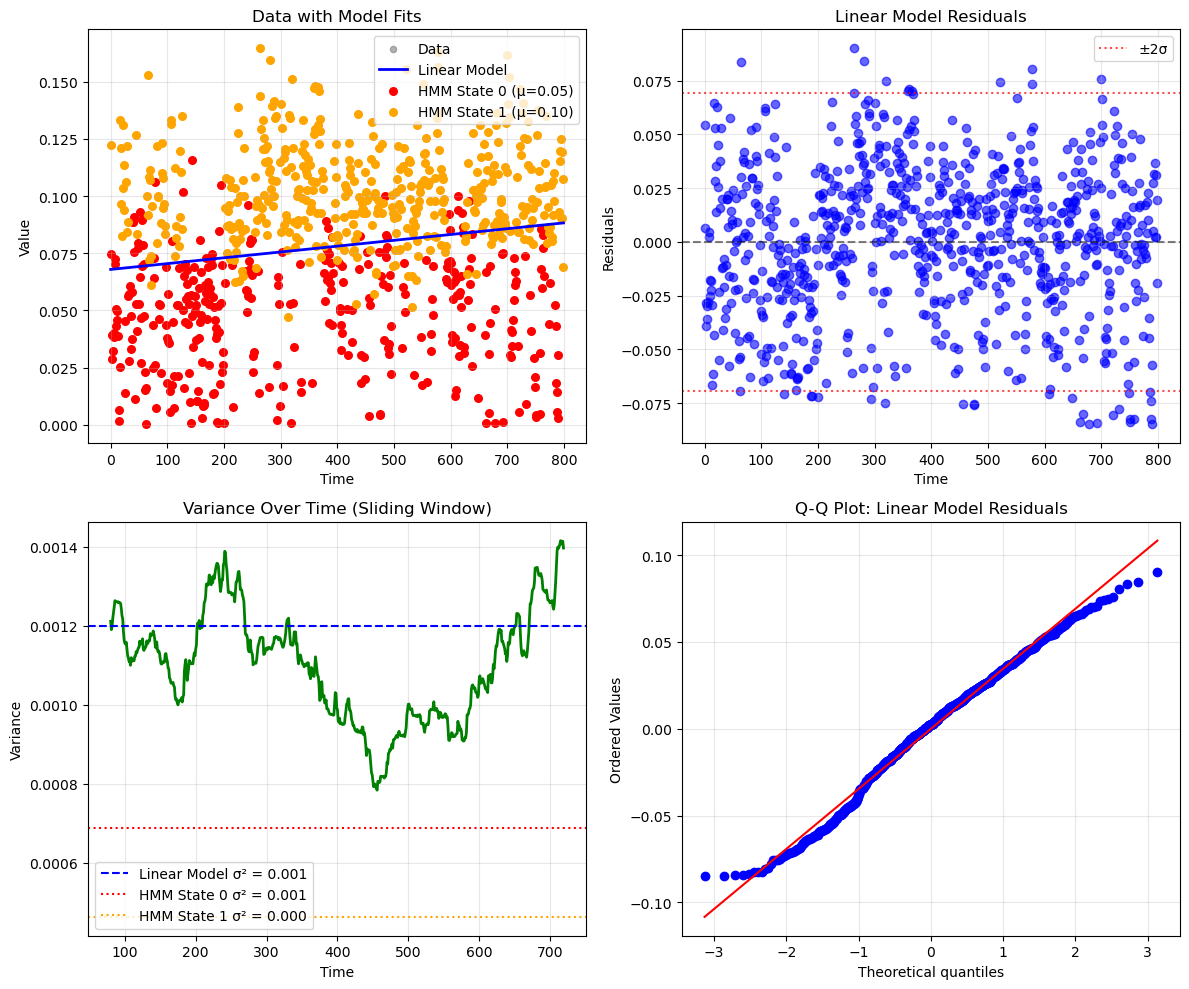

In [58]:
# Extract parameters for a specific animal
group = 'sparse_food'
animal = 0
hmm_params, linear_params = extract_model_params(per_animal_results, group, animal_id=animal)

# Get your animal's data  
y = all_speeds[group][animal]  # Assuming animal_id=0 corresponds to row 0
mask = ~np.isnan(y)
y_clean = y[mask]

# Create time array - this is what was missing!
t = np.arange(len(y))  # or whatever time points you used originally
t_clean = t[mask]

# Run diagnostics
fig = diagnose_hmm_vs_linear(y_clean, t_clean, hmm_params, linear_params)
plt.show()

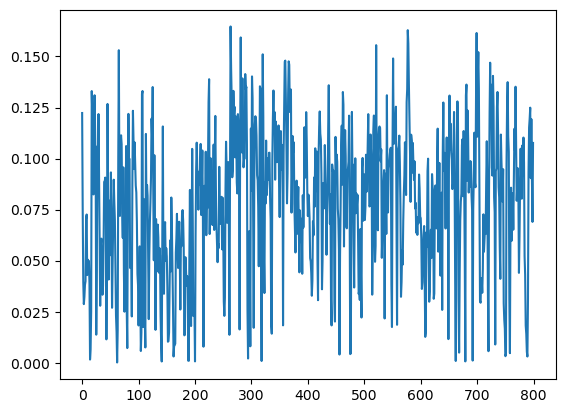

In [59]:
plt.plot(y)